# LINMA1702 modèles et méthodes d'optimisation
# Projet 2020-2021 : Logistique de la vaccination en Belgique
### Groupe 6 : Théau Lepouttre, Eliott Van Dieren et Nicolas Mil-Homens Cavaco


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mip import *

### Hypothèses

On considère une certaine population répartie en $m$ classes d'âge dans $n$ provinces en Belgique.
Parmi les personnes constituant cette population, on distingue deux parties distinctes:

* les personnes susceptibles 
* les autres, c'est-à-dire les malades, les vaccinés, les guéris et les morts.
    
On suppose cette population comme constante dans le temps.
Notre objectif est de minimiser le nombre de morts dû à l'épidémie.
Pour ce faire, on organise une campagne de vaccination qui s'étend sur une durée de $T$ jours et pour laquelle le buget est limité.

### Question 1.1

#### Notations

Dans ce premier modèle, on considère le cas d'un seul centre ($n=1$).
En outre, le stockage des vaccins n'est pas autorisé.

Soit les variables suivantes

* $x^t \equiv$ le nombre de doses qui arrivent au centre de vaccination au temps $t$;
* $y_i^t \equiv$ le nombre de doses administrées à la classe d'âge $i$ au temps $t$;
* $(v_s)_i^t \equiv$ le nombre de personnes susceptibles vaccinables parmi les personnes de la classe $i$ au temps $t$.
$(v_s)_i^t$ est considéré comme une variables car il dépend directement du nombre de personnes que l'on vaccine.

On note par $p_{init}$ la population totale initiale de susceptibles et $(n_s)_i^t$ le nombre de personnes susceptibles non-vaccinables parmi les personnes de la classe $i$ au temps $t$. Puisque cette deuxième partie des susceptibles n'est pas vaccinable, il ne s'agit pas d'une variable de notre problème. Dès lors, minimiser le nombre de morts revient à minimiser le nombre de morts parmi ceux que l'on peut vacciner. 

Soit les paramètres suivants

* $b_c^t \equiv$ le nombre de vaccins livrés dans l'entrepôt central;
* $b_l^t \equiv$ le nombre maximal de vaccins livrés au centre de vaccination au temps $t$;
* $b_v^t \equiv$ le nombre maximal de vaccins administrés au temps $t$;
* $c_{tr} \equiv$ le coût de transport;
* $c_v \equiv$ le coût de vaccination;
* $c_{tot} \equiv$ le budget total disponible.

On suppose en toute généralité que les contraintes de capacité ($b_\bullet^t$) peuvent varier dans le temps. 

Soit

* $\lambda_i^t \equiv$ la fraction parmi les personnes susceptibles tombant malade au jour $t$ pour la classe $i$.
* $\varepsilon_i^t \equiv$ la fraction parmi les personnes de la classe $i$ tombées malades au jour $t$ qui décèderont.
* $\mu_i \equiv$ la fraction de population disposée et autorisée à se faire vacciner.

Par la suite, les coefficients $\lambda$ et $\varepsilon$ sont supposés être des fonctions sinusoïdales du temps.
En outre, par convention, $\lambda_i^0 = 0\quad \forall i \in \{1, \ldots, m\}$ car avant le début de la campagne, on suppose qu'aucune personne n'est encore tombée malade.


#### Journée type
On fait l'hypothèse que les personnes tombent malade au soir (i.e. la nuit) et qu'on les vaccine au matin.
On considère qu'une journée se déroule de la manière suivante:

On suppose tout d'abord que nous avons une certaine population de susceptibles au matin.
Ensuite, le cas échéant, on effectue les vaccinations dans le centre. La population l'après-midi sera donc:

$$\mbox{susceptibles l'après-midi} = \mbox{susceptibles au matin} - \mbox{vaccinés}$$

Finalement, après avoir effectué la série de vaccins au matin, les personnes tombent malade au soir.

$$\mbox{susceptibles demain matin} = \mbox{susceptibles cette après-midi} - \mbox{malades ce soir}$$

On conclu donc que
$$\underbrace{(v_s)^t_i}_{susceptibles\ cette\ après-midi} = \underbrace{(v_s)^{t-1}_i}_{suscpetibles\ hier\ après-midi} - \underbrace{\lambda^{t-1}_i\ (v_s)^{t-1}_i}_{malades\ hier\ soir} - \underbrace{y^t_i}_{vaccinés\ ce\ matin}$$

#### Modèle

On identifie les contraintes suivantes, classées en $2$ catégories:
- 1. les contraintes de capacités et de budget:
    * Le budget total de la campagne de vaccination est limité $(1)$.
    * Le nombre de vaccins livrés est limité chaque jour par le nombre de vaccins disponibles dans l'entrepôt central $(2)$.
    * Le nombre de vaccins livrés est limité chaque jour par la limite du centre de vaccination $(3)$.
    * Le nombre de vaccins administrés est limité chaque jour $(4)$.
$$\\ $$
- 2. les contraintes physiques:
    * Le total de vaccins administrés au temps $t$ ne peut pas dépasser le nombre total de vaccins livrés la veille, et ce sur toute la durée de la campagne $(5)$.
    * Contrainte sur la population vaccinable et susceptible au temps $t$ (voir journée type ci-dessus) $(6)$.
    * Seules les personnes disposées et autorisées et qui ne sont pas tombées malade au soir peuvent se faire vacciner  le matin. On observe que, par la façon dont nous avons défini la contrainte 6, cela revient à imposer que $(v_s)^t_{i} \geq 0$ $(9)$.


Finalement, on prend la convention que $x^0 = 0$ et $y^0 = 0$. En d'autres termes aucun vaccin n'a été livré et n'a été adminstré la veille du début de la campagne $(8)$. On note également par $(v_s)^0_i$ la population initiale de susceptibles vaccinable $(7)$.

Le problème s'écrit donc

$$\begin{eqnarray*}
\min_{x, y, v_s}& \sum_{t=1}^{T} \sum_{i=1}^{m}  \varepsilon_i^t\ \lambda_i^t\ (v_s)_i^t \\
\sum_{t=1}^T \left(c_{tr}\ x^t + c_v \sum_{i=1}^{m} y_i^t\right) &\leq& c_{tot} \tag{1}\\
x^{t} &\leq & b_c^t  \tag{2}\\  
x^t &\leq& b_l^t \tag{3}\\
\sum_{i=1}^{m} y_i^t &\leq& b_v^t \tag{4}\\
x^{t-1} - \sum_{i=1}^{m} y_i^t &\geq& 0 \tag{5}\\
(v_s)_i^t - \left((1-\lambda_i^{t-1})\ (v_s)_i^{t-1} - y_i^{t} \right) &=&  0 \tag{6}\\
(v_s)_i^0 &=& \mu_i\ (p_{init})_i \tag{7}\\ %(n_s)_i^t - (n_{nv})_i^t \\
x^0,\ y^0 &=& 0 \tag{8}\\
x,\ y,\ v_s &\geq& 0 \tag{9}
\end{eqnarray*}$$

Lorsque cela n'est pas précisé, $t\in\{1,\ldots,T\}$ et $i\in\{1,\ldots,m\}$.

Si l'on veut effectuer le bilan de malades et de morts sur la population globale, c'est-à-dire en prenant en compte la population non-vaccinable, alors on peut calculer $(n_s)_i^t$ comme suit

$$\begin{eqnarray*}
(n_s)_i^t &=& (1-\lambda_i^{t-1})\ (n_s)_i^{t-1} \\
(n_s)_i^0 &=& (1-\mu_i)\ (p_{init})_i \\
(\lambda_i^0 &=& 0)
\end{eqnarray*}$$

Le nombre de morts total sera alors égal à 
$$\sum_{t=1}^{T} \sum_{i=1}^{m}  \varepsilon_i^t\ \lambda_i^t\ \left((v_s)_i^t + (n_s)^t_i\right)$$

#### Données du problème

In [2]:
T = 350               # durée de la campagne
m = 5                 # nombre de classes d'âge : [Young, Adult, Senior, Old, Centenarian]
c_tr  = 0             # Prix de livraison d'un vaccin
c_v   = 15            # prix d'administration d'un vaccin
c_tot = 100e6         # budget total autorisé
b_l   = 15e8          # nombre maximal de vaccins livrés par jour
b_v   = 14646         # nombre maximal de vaccins administrés par jour

# Population initiale
pop_init = np.array([3778123, 2846993, 2790883, 1390502, 111533])

# Fraction de malades
_lambda = lambda t: np.array([0.000298 * (1/5 + np.sin(t/50-1/5)**2),
                               0.000301 * (1/5 + np.sin(t/50)**2),
                               0.000204 * (1/5 + np.sin(t/50-1/5)**2),
                               0.000209 * (1/5 + np.sin(t/50-2/5)**2),
                               0.000329 * (1/5 + np.sin(t/50-2/5)**2)])

# Fraction de morts
_epsilon = lambda t: np.array([0.000100 * (6/5-t/1000),
                                0.000400 * (6/5-t/1000), 
                                0.005790 * (6/5-t/1000), 
                                0.027179 * (6/5-t/1000),
                                0.150000 * (6/5-t/1000)])

mu  = np.array([0.3, 0.6, 0.7, 0.9, 0.9])     # proportion de la population disposée à se faire vacciner.

b_c = np.zeros(T);
days = np.arange(1, T+1)
b_c_eff =  [80000, 80000,60000, 60000, 40000, 40000, 40000, 40000, 60000,60000,60000,60000,80000,80000,80000,
            80000,100000,100000,100000,100000,100000,100000,100000,100000,120000,120000,120000,120000,120000,
            120000,120000,120000,120000,120000,120000,120000,150000,150000,150000,150000,150000,150000,150000,
            150000,150000,150000,150000,150000,150000,150000]

for t in days-1:
    if(t != 0 and t % 7 == 0):
        b_c[t-1] = b_c_eff[t//7]

b_c[-1] = b_c_eff[-1] # On rajoute manuellement la dernière livraison

lambda_t  = [[_lambda(days)[i,t] for i in range(m)] for t in days-1]  + [[0.0]*m]
epsilon_t = _epsilon(days)

In [3]:
def init_variables(model, m, T):
    """
    Initialise les variables x,y,v_s au format: x[t], y[t][i], v_s[t][i].
    @args: 
        model: mip Model: modèle d'optimisation linéaire
        m: int: nombre de classes d'âge
        t: int: durée de la campagne
    @returns:
        x: List[Var]: variables de livraison
        y: List[List[Var]]: variables d'administration des vaccins
        v_s: List[List[Var]]: nombre de susceptibles vaccinables
    """
    x = [model.add_var() for _ in range(T+1)]
    y = model.add_var_tensor((T+1, m), 'y')
    v_s = model.add_var_tensor((T+1, m), 'v_s')
    
    return x, y, v_s

#### Résolution du modèle

Pour l'implémentation en python, on adopte la convention suivante:
- Les variables ont une dimension temporelle de $T+1$.
- Pour une variable $x$, $x[-1]$ désigne la valeur au jour $0$, c'est-à-dire la veille du début de la campagne.

In [4]:
model_I1 = Model('centre unique', sense=MINIMIZE, solver_name=CBC)

# Variables
x, y, v_s = init_variables(model_I1, m, len(days))

# Objectif
model_I1.objective = minimize(xsum(epsilon_t[i][t] * lambda_t[t][i] * v_s[t][i] for i in range(m) for t in days-1))

# Contraintes
model_I1 += xsum(c_tr * x[t] for t in days-1) + xsum(c_v * y[t][i] for i in range(m) for t in days-1) <= c_tot # (1)
for t in days-1:
    model_I1 += x[t] <= b_c[t]                                  # (2)
    model_I1 += x[t] <= b_l                                     # (3)
    model_I1 += xsum(y[t][i] for i in range(m)) <= b_v          # (4)
    model_I1 += x[t-1] - xsum(y[t][i] for i in range(m)) >= 0   # (5)
        
    for i in range(m):
        model_I1 += v_s[t][i] - (1 - lambda_t[t-1][i]) * v_s[t-1][i] + y[t][i] == 0  # (6)
        
# Conditions initiales   
model_I1 += x[-1] == 0                                 # (7)
for i in range(m):
    model_I1 += y[-1][i] == 0                          # (7)
    model_I1 += v_s[-1][i] - mu[i] * pop_init[i] == 0  # (8)

model_I1.optimize()
print(f"f(x,y) = {model_I1.objective_value}")

f(x,y) = 1932.3240491245413


In [5]:
# Calcul de la population non-vaccinable
n_s = np.zeros((T+1,m))
n_s[-1] = (1-mu) * pop_init
for t in days-1:
    for i in range(m):
        n_s[t][i] = (1 - lambda_t[t-1][i]) * n_s[t-1][i]

print(f"population morte totale = {model_I1.objective_value + sum(epsilon_t[i][t] * lambda_t[t][i] * n_s[t][i] for i in range(m) for t in days-1)}")

population morte totale = 2515.6908992907047


#### Résultats 

In [6]:
# Plot des résultats
population  = ["Young 0-29 ans", "Adult 30-49 ans", "Senior 50-69 ans", "Old 70-89 ans", "Centenarian 90-   ans"]
livraisons  = [x[t].x for t in days-1]
vaccination = [[y[t][i].x for t in days-1] for i in range(m)]
susceptible = [[(n_s[t][i] + v_s[t][i].x) for t in days-1] for i in range(m)]
pop_s       = [sum((n_s[t][i] + v_s[t][i].x) for i in range(m)) for t in days-1]
pop_malade  = [sum( lambda_t[t][i] * (n_s[t][i] + v_s[t][i].x) for i in range(m)) for t in days-1]
pop_morte   = [sum(epsilon_t[i][t] * lambda_t[t][i] * (n_s[t][i] + v_s[t][i].x) for i in range(m)) for t in days-1]

C_tot = sum(c_tr * x[t].x for t in days-1) + sum(c_v * y[t][i].x for i in range(m) for t in days-1)
print(f"Coût de la campagne = {C_tot:.1f}\nBudget disponible = {c_tot}")
print(f"Budget non-dépensé = {c_tot - C_tot}")

Coût de la campagne = 10764810.0
Budget disponible = 100000000.0
Budget non-dépensé = 89235190.0


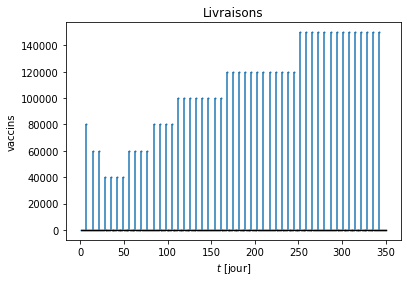

In [7]:
# Plot des livraisons
plt.figure()
plt.title("Livraisons")
markerline, stemlines, baseline = plt.stem(days, livraisons)
plt.xlabel("$t$ [jour]", fontsize=10)
plt.ylabel("vaccins", fontsize=10)
baseline.set_color('k')
baseline.set_linewidth(1)
markerline.set_markersize(1)
plt.show()   

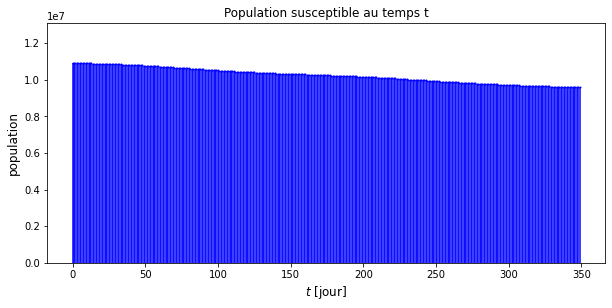

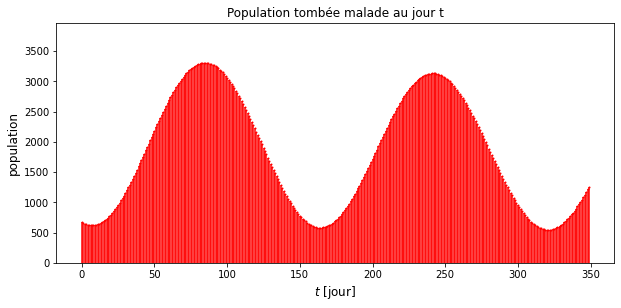

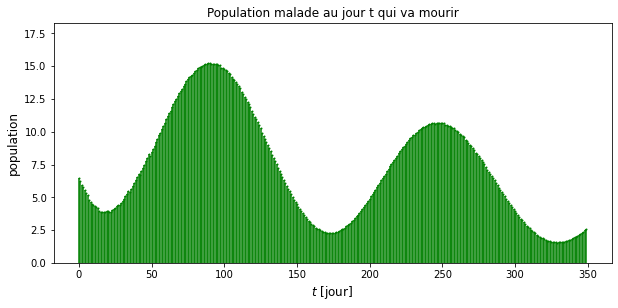

In [8]:
# Plot des populations
pop = [pop_s, pop_malade, pop_morte]
color = ['b','r','g']
titres_pop = ["Population susceptible au temps t", "Population tombée malade au jour t", "Population malade au jour t qui va mourir"]

for i in range(3):
    plt.figure(figsize=(10, 15))
    plt.subplot(3, 1, i + 1)
    plt.title(titres_pop[i])
    markerline, stemlines, baseline = plt.stem(days-1, pop[i], "-"+color[i])
    plt.xlabel("$t$ [jour]", fontsize=12)
    plt.ylabel("population", fontsize=12)
    plt.ylim((0, max(pop[i])*1.2))
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_color(color[i])
    markerline.set_markersize(1)
    plt.show()

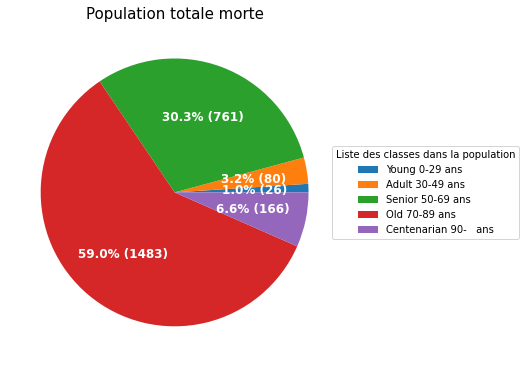

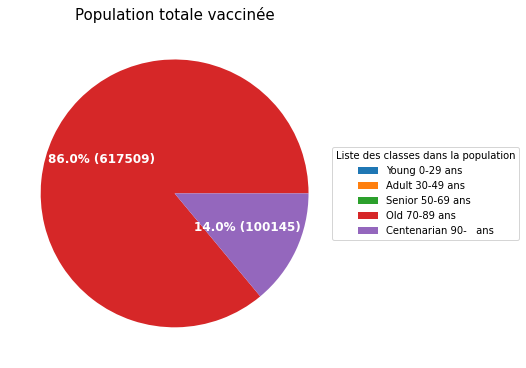

In [9]:
# Sources : fortement inspiré du code à l'adresse :
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

print()
data_pmorte    = [sum(epsilon_t[i][t] * lambda_t[t][i] * (n_s[t][i] + v_s[t][i].x) for t in days-1) for i in range(m)]
data_pvaccinee = [sum(y[t][i].x for t in days-1) for i in range(m)]
data = [data_pmorte, data_pvaccinee]
titles = ["Population totale morte", "Population totale vaccinée"]

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}% ({:d})".format(pct, absolute) if absolute > 1e-5 else ""


def simpleCamembert(data, titles):
    fig, ax = plt.subplots(figsize=(6, 9), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(d, autopct=lambda pct: func(pct, d),textprops=dict(color="w"))
    
    ax.legend(wedges, population, title="Liste des classes dans la population",
          loc="center",
          bbox_to_anchor=(1, 0, 0.5, 1))


    plt.setp(autotexts, size=12, weight="bold")
    ax.set_title(title, fontsize=15)
    plt.show()

        
for d,title in zip(data, titles):
    simpleCamembert(d, title)

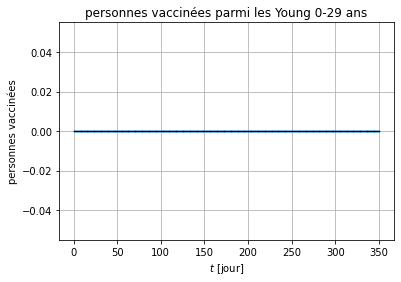

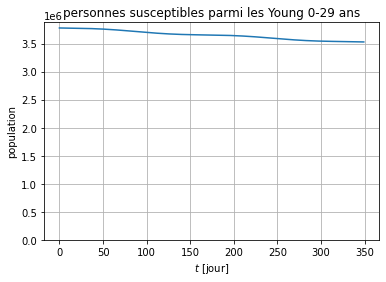

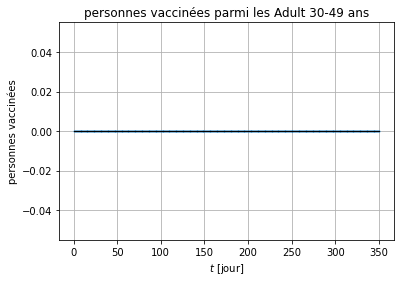

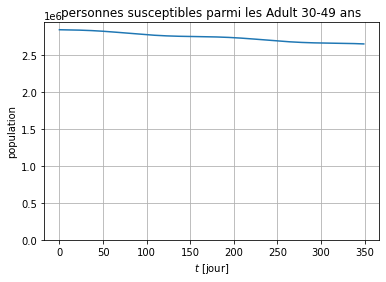

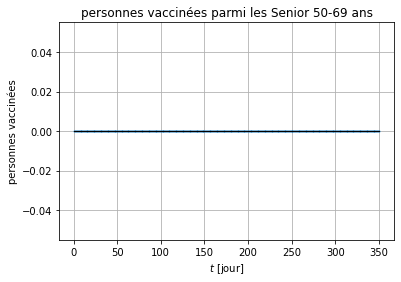

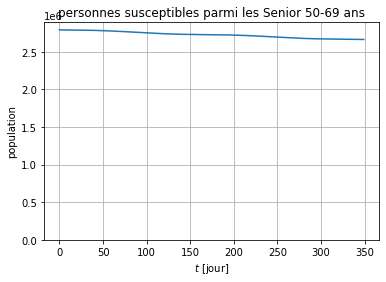

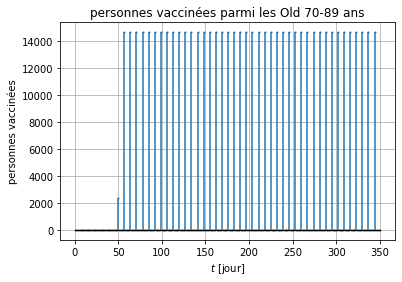

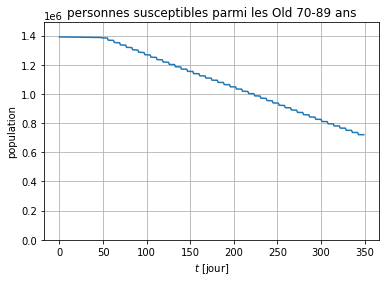

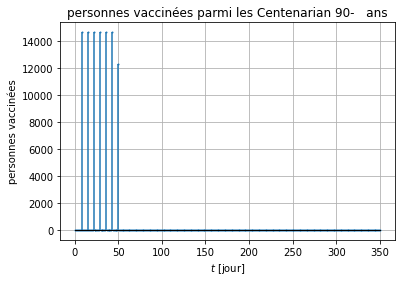

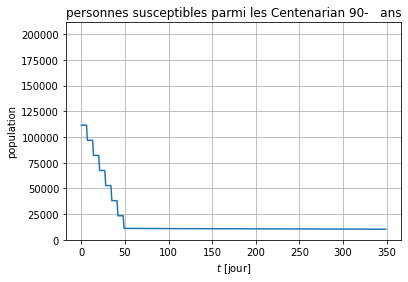

In [10]:
# Titres
titres = [f"{population[i]}" for i in range(m)]

plt.figure("Question 1.1")
for i in range(5):
        plt.title("personnes vaccinées parmi les " + titres[i])
        markerline, stemlines, baseline = plt.stem(days, vaccination[i])       
        plt.xlabel("$t$ [jour]", fontsize=10)
        plt.ylabel("personnes vaccinées", fontsize=10)

        baseline.set_color('k')
        baseline.set_linewidth(1)
        markerline.set_markersize(1)
        plt.grid()
        plt.show()
        
        plt.title("personnes susceptibles parmi les " + titres[i])
        plt.plot(days-1, susceptible[i])
        plt.xlabel("$t$ [jour]", fontsize=10)
        plt.ylabel("population", fontsize=10)
        plt.ylim((0, max(susceptible[i]) + 1e5))
        plt.grid()
        plt.show()

#### Analyse des résultats obtenus

D'un point de vue global, on remarque que la solution de notre modèle est fortement corrélée aux coefficients $\lambda$ (fractions des malades) et $\varepsilon$ (fraction des mourants). Il s'agit d'une conséquence directe de notre objectif qui est de minimiser le nombre de mort total. Cela fait sens de voir que les classes présentant le plus grand taux d'indidence et de décès, pondérés par la taille de la classe d'âge, soient vaccinées en premier.

En effet, à la lecture des données fournies, on remarque que ces coefficients sont bien plus élevés pour les groupes des 'centenarian' (90+ ans) et des 'old' (70-89 ans). Par conséquent, il s'agit des seules tranches d'âges que l'on vaccine, et ce malgré que d'autres tranches d'âges soient plus nombreuses (par exemple les jeunes et les adultes).
Cependant, on constate que la tranche des 'senior' a un pourcentage de morts plus élevé (30.3%) que les 'centenarian' (6.6%). Cela s'explique par le fait que le taux de mortalité $\varepsilon$ pour la classe des 'centenarian' est bien plus élevé que celui des 'senior'. Dès lors, si nous ne commençons pas par vacciner les 'centenarian' en premier lieu, le nombre de morts chez ces derniers finira par dépasser celui des 'senior'.

Par ailleurs, comme prévu, la population suceptible de tomber malade diminue bien durant la campagne de vaccination.
En regardant de plus près les graphes, on remarque une progression décroissante en escalier pour les tranches d'âges visées par la campagne. Une chute correspond en effet à un jour où l'on vaccine grâce aux vaccins livrés la veille. 
Les autres populations diminuent également mais dans une moindre mesure, puisqu'une certaine fraction tombe malade chaque jour et quitte donc la catégorie de "susceptible".

Ensuite, d'un point de vue des contraintes, on observe tout d'abord que la contrainte de coût n'est pas serrée. En effet, nous obtenons un surplus de 89235190 euros non dépensés. De ce fait, puisqu'aucun stockage n'est autorisé, on transporte la totalité des vaccins disponibles au hangar central vers le centre de vaccination afin qu'ils puissent être administrés le lendemain. 

Finalement, on observe sur les graphes des classe 'centenarian' et 'old' que la contrainte de vaccination est, quant à elle, serrée dès qu'une livraison a été faite la veille.
Notre modèle est donc contraint par l'administration des vaccins aux différentes classes d'âge. On note également que la contrainte de livraison étant infinie pour ce premier modèle, elle n'est pas limitante d'un point de vue de l'objectif.


### Question 1.2

#### Modèle

On considère à présent le cas de $n$ provinces. Dans le cas de la Belgique, en comptant Bruxelles comme une province, on aura $n=11$.
On autorise également le stockage des vaccins dans les centres.

Par rapport au modèle précédent, on introduit 
* $z_j^t \equiv$ le nombre de vaccins mis en stock au temps $t$ et disponibles pour le lendemain dans le centre de la province $j$, variable. Ces vaccins ne sont donc pas administrés au jour $t$.
* $(c_s)_j \equiv$ le coût associé au stockage d'un vaccin dans le centre $j$, connu.

Comme pour le point précédent, on impose que les vaccins livrés au jour $t$ ne peuvent être administrés qu'à partir du lendemain (au jour $t+1$). Dans ce modèle, on fait l'hypothèse qu'un vaccin livré au jour $t$ peut être stocké gratuitement jusqu'au lendemain et que l'on ne paye qu'en cas de prolongement sur sa durée de stockage.

Outre les contraintes identifiées plus haut, on ajoute le fait que tous les vaccins qui sont arrivés la veille ou qui étaient en stock la veille peuvent, soit être administrés, soit être mis en stock pour le lendemain $(6)$.
On ajoute également la contrainte sur la capacité de stockage dans chaque province et chaque jour $(5)$.

Finalement, puisqu'on suppose que chaque province $j$ subit l'épidémie de manière indépendante, les contraintes sont propres à chacune d'entres elles, excepté les contraintes de coût total $(1)$ et de vaccins disponibles au hangar central $(2)$.

De manière similaire à la question 1.1, on prend la convention $x^0 = 0$, $y^0 = 0$ et $z^0 = 0$ car aucun vaccin n'a été livré, administré ou mis en stock la veille du début de la campagne $(10)$.

On rappelle également que $\lambda_{ij}^0 = 0\quad \forall i \in \{1, \ldots, m\},\ \forall j \in \{1, \ldots, n\}$ comme cela a été précisé à la question précédente.

Le problème s'écrit donc

$$\begin{eqnarray*}
\min_{x, y, z, v_s}& \sum_{t=1}^{T} \sum_{i=1}^{m} \sum_{j=1}^{n} \varepsilon_{ij}^t\ \lambda_{ij}^t 
(v_s)_{ij}^t & \\
\sum_{t=1}^T \sum_{j=1}^{n} \left((c_{tr})_j\ x_j^t + (c_v)_j \sum_{i=1}^{m} y_{ij}^t + (c_s)_j\ z_j^t\right) &\leq& c_{tot} \tag{1}\\
\sum_{j=1}^n x_j^{t} &\leq & b_c^t \tag{2}\\ 
x_j^t &\leq& (b_l)_j^t \tag{3}\\
\sum_{i=1}^{m} y_{ij}^t &\leq& (b_v)_j^t \tag{4}\\
z_j^t &\leq& (b_s)_j^t \tag{5}\\
x_j^{t-1} + z_j^{t-1} - \sum_{i=1}^{m} y_{ij}^t - z_j^{t} &\geq& 0 \tag{6}\\
(v_s)_{ij}^t - \left((1-\lambda_{ij}^{t-1})\ (v_s)_{ij}^{t-1} - y_{ij}^{t} \right) &=&  0 \tag{7}\\
(v_s)_{ij}^0 &=& \mu_i\ (p_{init})_{ij}\tag{8}\\ 
x^0,\ y^0,\ z^0 &=& 0 \tag{9} \\
x,\ y,\ z,\ v_s &\geq& 0 \tag{10}
\end{eqnarray*}$$

A nouveau, lorsque cela n'est pas précisé, $t\in\{1,\ldots,T\}$, $i\in\{1,\ldots,m\}$ et $j\in\{1,\ldots,n\}$.

De la même manière qu'à la question 1, on peut effectuer le bilan de malades et de morts sur la population globale en calculant la population non-vaccinable:

$$\begin{eqnarray*}
(n_s)_{ij}^t &=& (1-\lambda_{ij}^{t-1})\ (n_s)_{ij}^{t-1} \\
(n_s)_{ij}^0 &=& (1-\mu_i)\ (p_{init})_{ij} \\
(\lambda_{ij}^0 &=& 0)
\end{eqnarray*}$$

Le nombre de morts total sera alors égal à 
$$\sum_{t=1}^{T} \sum_{i=1}^{m} \sum_{j=1}^{n} \varepsilon_{ij}^t\ \lambda_{ij}^t 
\left((v_s)_{ij}^t + (n_s)_{ij}^t \right).$$

#### Données du problème

In [11]:
# Fonctions utiles à l'algorithme

def init_variables(model, m, n, T):
    """
    Initialise les variables x,y,z,v_s au format: x[t][j], y[t][j][i], z[t][j], v_s[t][j][i].
    
    @args: 
        model: mip model
        m: int: nombre de classes d'âge
        n: int: nombre de provinces
        T: int: durée de la campagne
    
    @returns:
        x: List[List[Var]]: variables de livraison
        y: List[List[List[Var]]]: variables d'administration des vaccins
        z: List[List[Var]]: variables de stockage
        v_s: List[List[List[Var]]]: nombre de susceptibles vaccinables
    """  
    x = model.add_var_tensor((T+1, n), 'x')
    y = model.add_var_tensor((T+1, n, m), 'y')
    z = model.add_var_tensor((T+1, n), 'z')
    v_s = model.add_var_tensor((T+1, n, m), 'v_s')
    
    return x,y,z,v_s

def init_population(m, n):
    """
    Initialise la population de susceptibles au format: pop_init[j][i].
    
    @args: 
        m: int: nombre de classes d'âge
        n: int: nombre de provinces
    
    @returns: 
        pop_init: List[List[int]]: population de susceptibles initiale dans chaque province.
        province: List[String]: noms des provinces.
        tranche: List[String]: noms des tranches
        _lambda: Panda DataFrame: fraction de la population de malade au temps 0.
    """
    Fraction_malade_province = pd.read_csv("Données-v1.2/Fraction_malade_province.csv")
    _lambda = Fraction_malade_province.set_index('Tranche')
    province = _lambda.columns.to_numpy()
    tranche  = _lambda.index.to_numpy()
    
    population_Province = pd.read_csv("Données-v1.2/Population_province.csv")
    population_Province2 = population_Province.set_index('Province')["Population"]
    
    pop_init = np.array([[population_Province2[province[j]][4],
                 population_Province2[province[j]][0],
                 population_Province2[province[j]][3],
                 population_Province2[province[j]][2],
                 population_Province2[province[j]][1]]
                 for j in range(n)])
    
    return pop_init, province, tranche, _lambda

In [12]:
# Données du problème
T_2 = 380             # durée de la campagne
m = 5                 # nombre de classes d'âge : [Young, Adult, Senior, Old, Centenarian]
n = 11                # Nombre de provinces
days_2 = np.arange(1, T_2+1)

# Initialision de la population
pop_init, province, tranche, _lambda = init_population(m, n); print(f"tranche = {tranche}\nprovince = {province}")

# Initialisation de la fraction de malade au format lambda_t[t][i][j]
lambda_t = [[
    [_lambda[province[j]][tranche[0]]  * (1/5 + np.sin(t/50-1/5)**2) for j in range(n)],
    [_lambda[province[j]][tranche[1]]  * (1/5 + np.sin(t/50)**2)     for j in range(n)],
    [_lambda[province[j]][tranche[2]]  * (1/5 + np.sin(t/50-1/5)**2) for j in range(n)],
    [_lambda[province[j]][tranche[3]]  * (1/5 + np.sin(t/50-2/5)**2) for j in range(n)],
    [_lambda[province[j]][tranche[4]]  * (1/5 + np.sin(t/50-2/5)**2) for j in range(n)]] for t in days_2-1] \
  + [np.zeros((m,n))]

# Initialisation de la fraction de morts au format _epsilon[t][i]
_epsilon  = lambda t: np.array([0.000100 * (6/5-t/1000),
                                0.000400 * (6/5-t/1000), 
                                0.005790 * (6/5-t/1000), 
                                0.027179 * (6/5-t/1000),
                                0.150000 * (6/5-t/1000)])
epsilon_t = _epsilon(days_2)

# Initialisation de la fraction de personnes vaccinables
mu = np.array([0.3, 0.6, 0.7, 0.9, 0.9])

# Initialisation des contraintes
constr = pd.read_csv("Données-v1.2/Centres_vaccination.csv")
constr = constr.set_index('Province')

c_tot = 100e6                                                          # budget total autorisé
c_tr  = [constr['CoutTransport'][province[j]] for j in range(n)]       # Prix de livraison d'un vaccin
c_v   = [constr['CoutDose'][province[j]] for j in range(n)]            # prix d'administration d'un vaccin
c_s   = [constr['CoutStockage'][province[j]] for j in range(n)]        # Coût de stockage
b_l   = [constr['CapaciteTransport'][province[j]] for j in range(n)]   # nombre maximal de vaccins livrés par jour
b_v   = [constr['CapaciteVaccination'][province[j]] for j in range(n)] # nombre maximal de vaccins administrés par jour
b_s   = [constr['CapaciteStockage'][province[j]] for j in range(n)]    # nombre de vaccins stockables

# Vaccins livrés au hangar central
b_c = np.zeros(350);
b_c_eff =  [80000, 80000,60000, 60000, 40000, 40000, 40000, 40000, 60000,60000,60000,60000,80000,80000,80000,
            80000,100000,100000,100000,100000,100000,100000,100000,100000,120000,120000,120000,120000,120000,
            120000,120000,120000,120000,120000,120000,120000,150000,150000,150000,150000,150000,150000,150000,
            150000,150000,150000,150000,150000,150000,150000]
for t in np.arange(350):
    if(t != 0 and t % 7 == 0):
        b_c[t-1] = b_c_eff[t//7]
        
b_c[-1] = b_c_eff[-1] # On rajoute manuellement la dernière livraison

# On prolonge la longueur de b_c de 30 jours
b_c = np.concatenate((b_c, np.zeros(30)))

tranche = ['young' 'adult' 'senior' 'old' 'centanarian']
province = ['Province de Flandre orientale' 'Province de Flandre occidentale'
 'Province du Brabant flamand' 'Province d’Anvers' 'Province du Hainaut'
 'Province de Liège' 'Province du Limbourg' 'Province du Luxembourg'
 'Province du Brabant wallon' 'Province de Namur' 'Bruxelles']


#### Résolution du modèle

In [13]:
def solve_model(APO_modif='None', modif=None):
    """
    Résout le modèle d'optimisation linéaire pour n=11 centres.
    Possibilité de vérifier l'analyse post-optimale avec APO_modif.
    
    @args:
        APO_modif: String: modification sur une contrainte de capacité: b_c, b_l, b_v ou b_s.
        modif: numpy array: Valeurs des modifications faites.
        
    @returns:
        model_I2: mip model
        x: var_tensor: variable de transport
        y: var_tensor: variable de vaccination
        z: var_tensor: variable de stockage
        v_s: var_tensor: population susceptible et vaccinable
    """
    
    # Création du modèle
    model_I2 = Model('multi-centre', sense=MINIMIZE, solver_name=CBC)

    # Initialisation des variables
    x,y,z,v_s = init_variables(model_I2, m, n, T_2)
    
    # Objectif
    model_I2.objective = minimize(xsum(epsilon_t[i][t] * lambda_t[t][i][j] * v_s[t][j][i]
                                    for j in range(n) for i in range(m) for t in range(len(days_2))))

    # Contrainte sur le coût total
    model_I2 += xsum(c_tr[j] * x[t][j] for j in range(n) for t in days_2-1) \
             + xsum(c_v[j] * y[t][j][i] for i in range(m) for j in range(n) for t in days_2-1) \
             + xsum(c_s[j] * z[t][j] for j in range(n) for t in days_2-1) <= c_tot      # (1)

    # Contrainte sur la quantité de vaccins livrables au temps t à tous les centres
    for t in days_2-1: 
        if APO_modif == 'b_c':
            model_I2 += xsum(x[t][j] for j in range(n)) <= b_c[t] + modif[t]           
        else:
            model_I2 += xsum(x[t][j] for j in range(n)) <= b_c[t]                       # (2)

    # Contrainte sur le nombre de vaccins livrables au centre j et au temps t    
    for t in days_2-1:       
        for j in range(n):  
            if APO_modif == 'b_l':
                model_I2 += x[t][j] <= b_l[j] + modif[j][t] 
            else:
                model_I2 += x[t][j] <= b_l[j]                                           # (3)

    # Contrainte sur le nombre de vaccins administrables au temps t    
    for t in days_2-1:       
        for j in range(n):
            if APO_modif == 'b_v':
                model_I2 += xsum(y[t][j][i] for i in range(m)) <= b_v[j] + modif[j][t]
            else:
                model_I2 += xsum(y[t][j][i] for i in range(m)) <= b_v[j]                # (4)

    # Contrainte sur le nombre de vaccins stockables au centre j et au temps t    
    for t in days_2-1:       
        for j in range(n):   
            if APO_modif == 'b_s':
                model_I2 += z[t][j] <= b_s[j] + modif[j][t]
            else:
                model_I2 += z[t][j] <= b_s[j]                                           # (5)

    # Contrainte physique sur la quantité de vaccins disponibles et stockables au temps t     
    for t in days_2-1:
        for j in range(n):
            model_I2 += x[t-1][j] + z[t-1][j] - xsum(y[t][j][i] for i in range(m)) - z[t][j] >= 0  # (6)

    # Contrainte sur le nombre de personnes vaccinables au temps t        
    for t in days_2-1:          
        for j in range(n): 
            for i in range(m):
                model_I2 += v_s[t][j][i] - (1 - lambda_t[t-1][i][j]) * v_s[t-1][j][i] + y[t][j][i] == 0  # (7) 
                
    # Conditions initiales
    for j in range(n):   
        model_I2 += z[-1][j] == 0  # (9)
        model_I2 += x[-1][j] == 0  # (9)
        for i in range(m):
            model_I2 += y[-1][j][i] == 0  # (9)
            model_I2 += v_s[-1][j][i] == mu[i] * pop_init[j][i]  # (8)

    print(model_I2.optimize())
    print(f"f(x,y,z) = {model_I2.objective_value}")
    return model_I2, x, y, z, v_s

model_I2, x, y, z, v_s = solve_model()

OptimizationStatus.OPTIMAL
f(x,y,z) = 659.3158306475787


In [14]:
# Caclul de la population non-vaccinable
n_s = np.zeros((T_2+1, n, m))

# Population initiale
for j in range(n): 
    n_s[-1][j] = (1-mu) * pop_init[j]
    
for t in days_2-1:          
    for j in range(n): 
        for i in range(m):
            n_s[t][j][i] = (1 - lambda_t[t-1][i][j]) * n_s[t-1][j][i]

print(f"population morte totale = {model_I2.objective_value + sum(epsilon_t[i][t] * lambda_t[t][i][j] * n_s[t][j][i] for i in range(m) for j in range(n) for t in days_2-1)}")

population morte totale = 1149.4909734458306


#### Résultats 

In [15]:
populationNames  = ["Young 0-29 ans", "Adult 30-49 ans", "Senior 50-69 ans", "Old 70-89 ans", "Centenarian 90-   ans"]
livraisons  = [[x[t][j].x for t in days_2-1] for j in range(n)]
vaccination = [[sum(y[t][j][i].x for j in range(n)) for t in days_2-1] for i in range(m)]
stockage    = [[z[t][j].x for t in days_2-1] for j in range(n)]

population = [sum((v_s[t][j][i].x + n_s[t][j][i]) for j in range(n) for i in range(m)) for t in days_2-1]
population_classe = [[sum((v_s[t][j][i].x + n_s[t][j][i]) for j in range(n)) for i in range(m)] for t in days_2-1]
pop_morte  = [sum(epsilon_t[i,t] * lambda_t[t][i][j] * (v_s[t][j][i].x + n_s[t][j][i]) for i in range(m) for j in range(n)) for t in days_2-1]

colors = np.array(["red","steelblue","yellow","springgreen","cyan","magenta","darkseagreen","tomato","orange","violet", "green"])

C_tot = sum(c_tr[j] * x[t][j].x for j in range(n) for t in days_2-1) \
      + sum(c_v[j] * y[t][j][i].x for i in range(m) for j in range(n) for t in days_2-1) \
      + sum(c_s[j] * z[t][j].x for j in range(n) for t in days_2-1)

print(f"Coût de la campagne = {C_tot}")
print(f"Budget disponible   = {c_tot}")
print(f"Budget non dépensé  = {c_tot - C_tot}")

Coût de la campagne = 84350380.39760125
Budget disponible   = 100000000.0
Budget non dépensé  = 15649619.602398753


#### Graphes des livraisons, stockage et vaccinations par régions ou classes d'âge

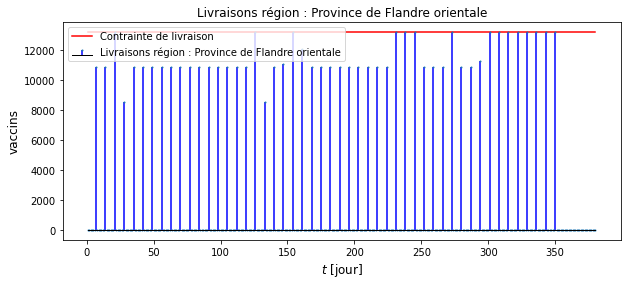

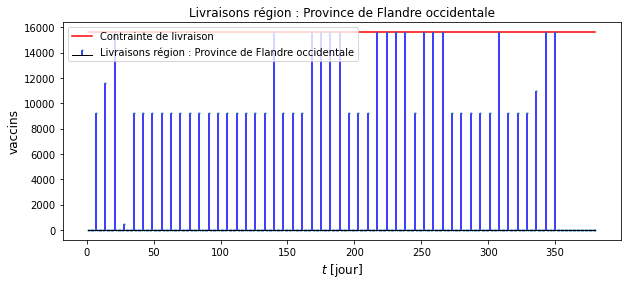

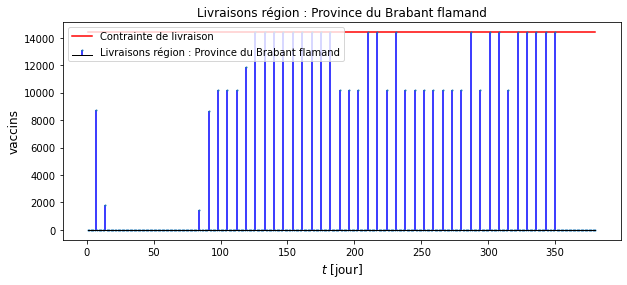

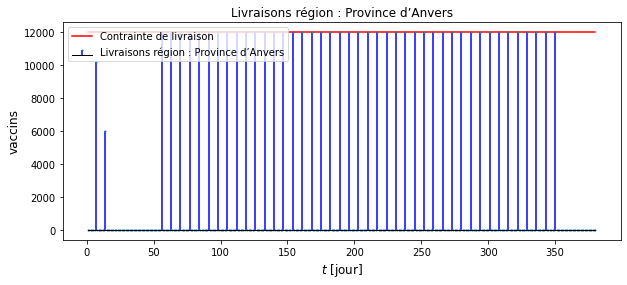

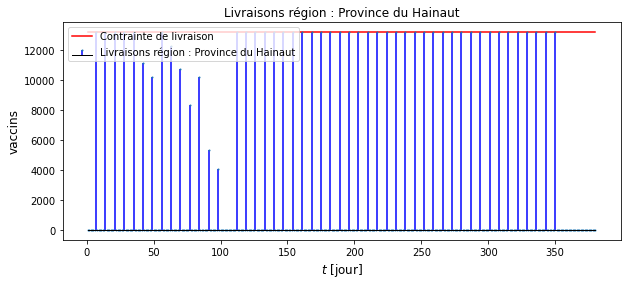

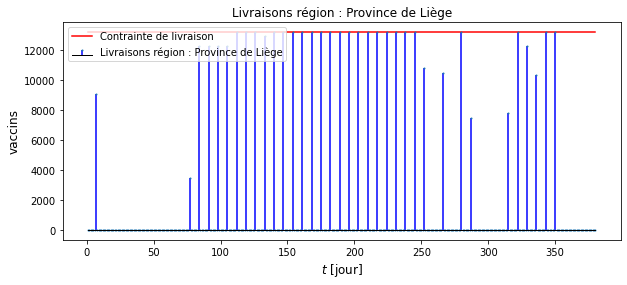

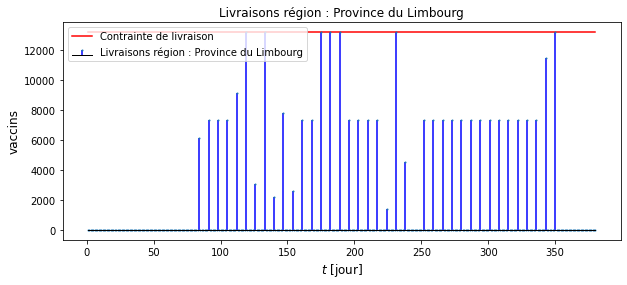

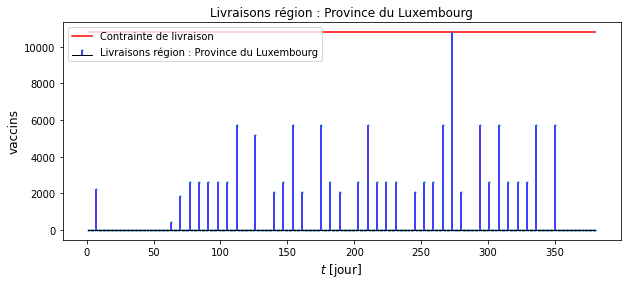

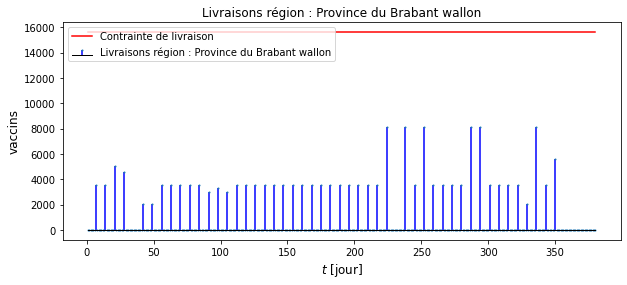

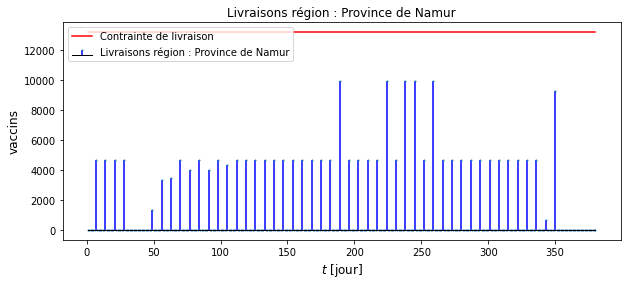

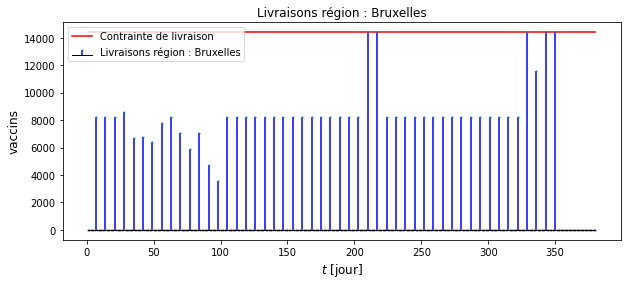

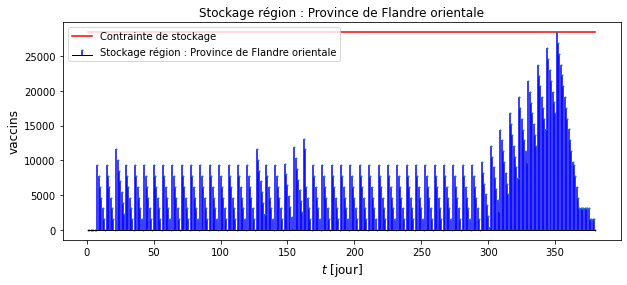

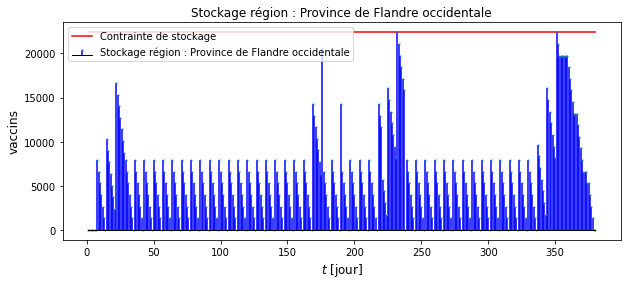

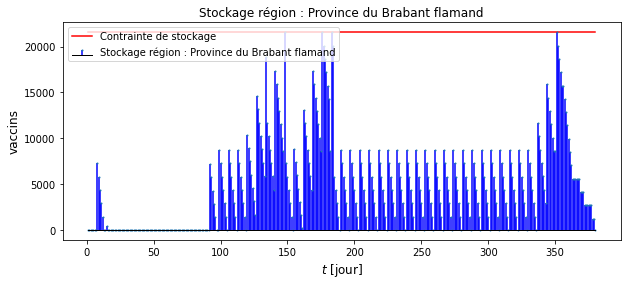

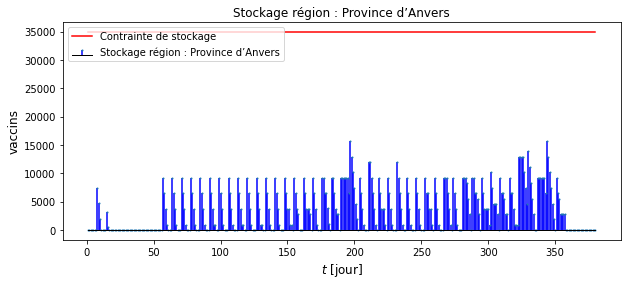

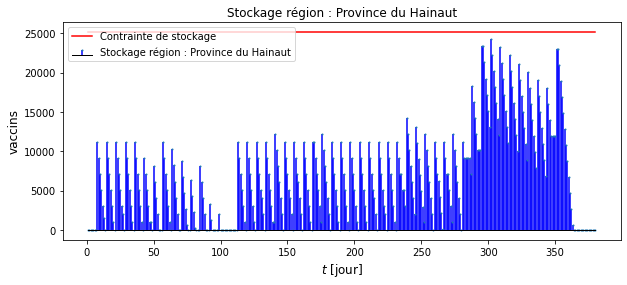

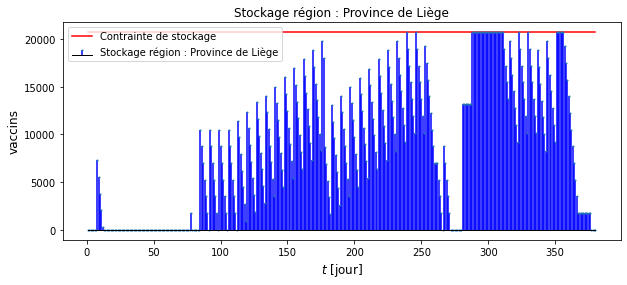

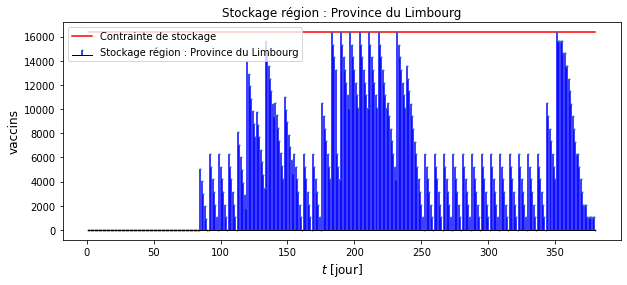

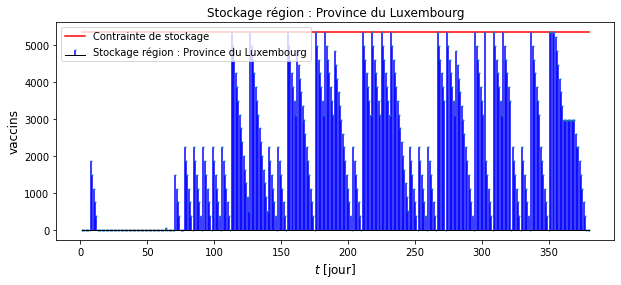

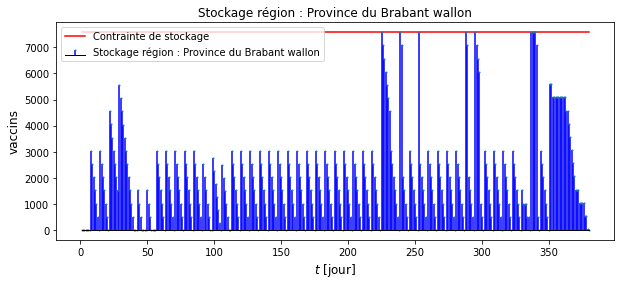

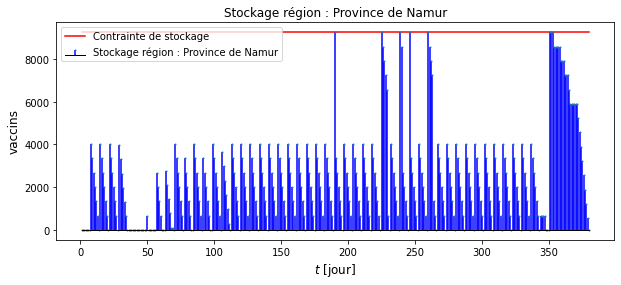

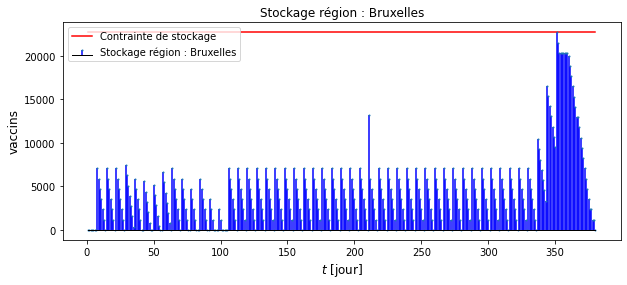

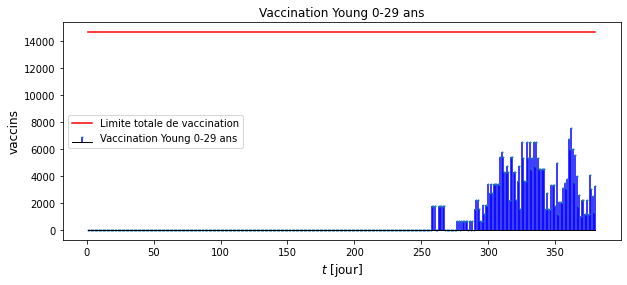

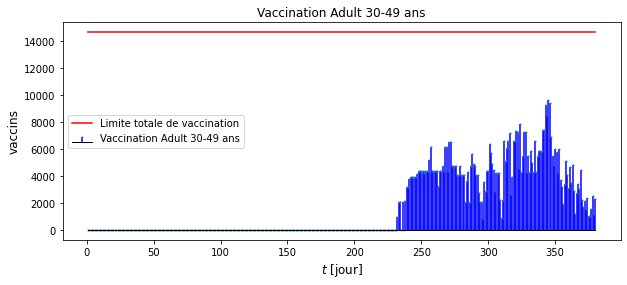

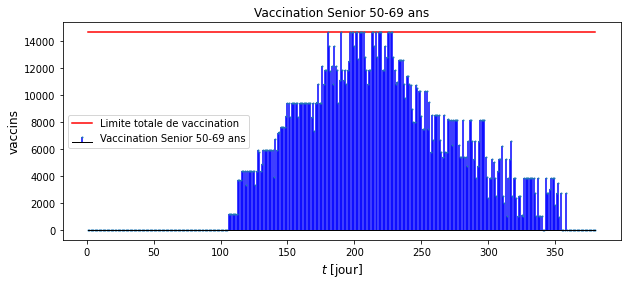

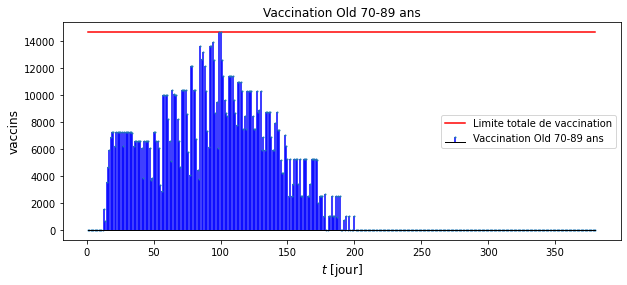

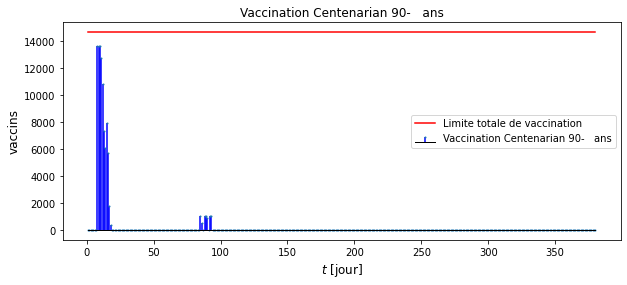

In [16]:
def plot_bilan(t, data, title, *constr, ylabel='vaccins',constr_name=[], 
               linestyle=[], label_loc=None, figsize=(10,4), label=True, grid=False):
    
    plt.figure(figsize=figsize)
    plt.title(title)
    for i in range(len(constr_name)):
        plt.plot(t, constr[i], colors[i % len(colors)], linestyle=linestyle[i], label=constr_name[i])
        
    if label:
        markerline, stemlines, baseline = plt.stem(t, data, "b", label=title)
    else:
        markerline, stemlines, baseline = plt.stem(t, data, "b")
        
    plt.xlabel("$t$ [jour]", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_markersize(1)
    if label or len(constr_name) != 0:
        plt.legend(loc=label_loc)
    if grid: plt.grid()
    plt.show()
    
# Plot des livraisons
for j in range(n): 
    plot_bilan(days_2, livraisons[:][j], f"Livraisons région : {province[j]}",
               np.ones_like(days_2)*b_l[j],
               linestyle=['solid'], 
               constr_name=["Contrainte de livraison"],
               label_loc='upper left')
    
# Plot des stockages
for j in range(n): 
    plot_bilan(days_2, stockage[:][j], f"Stockage région : {province[j]}",
               np.ones_like(days_2)*b_s[j], linestyle=['solid'], 
               constr_name=["Contrainte de stockage"],
               label_loc='upper left')
    
# Plot des vaccinations
for i in range(m): 
    plot_bilan(days_2, vaccination[:][i], f"Vaccination {populationNames[i]}",
              np.ones_like(days_2)*sum(b_v), linestyle=['solid'], 
              constr_name=["Limite totale de vaccination"])

**Analyse des graphes**

Nous avons représenté ci-dessus les livraisons et les stockages effectués dans les différentes provinces de Belgique ainsi que les vaccinations faites sur les différentes classes d'âge.
De plus, on représente par une ligne rouge la contrainte de capacité associée.

On observe tout d'abord que les contraintes de livraisons sont essentiellement serrées pour les provinces d'Anvers, du Haintaut et de Liège. Nous verrons plus loin, lors de l'analyse post-optimale, qu'il s'agit en effet des provinces pour lesquelles une modification de cette contrainte de livraison permettra de diminuer plus facilement la valeur de l'objectif.

Ensuite, concernant le stockage, la contrainte associée est pratiquement inactive (exceptée pour certains jours précis et dans des régions précises). On observe sur les différents graphes des "pics de stockages" que ceux-ci coïncident avec les jours où l'on livre. Les chutes de stockage qui suivent correspondent, quant à elles, à la consommation du stock lors des vaccinations faites les jours suivants. On note toutefois que, pour la province de Liège, entre les jours 290 et 320 environ, la contrainte de stockage est active. Cela signifie qu'aucune vaccination n'est faite sur cette periode et que la totalité des vaccins est restée en stock.

Finalement, de manière similaire à la question précédente, on observe que nous commençons par vacciner les personnes les plus âgées pour terminer par la classe dans plus jeunes. Il nous est possible de vacciner les jeunes car le stockage des vaccin est à présent autorisé. Cela nous permet donc de vacciner plus de monde. 

#### Graphes des livraisons, stockage et vaccinations d'un point de vue global

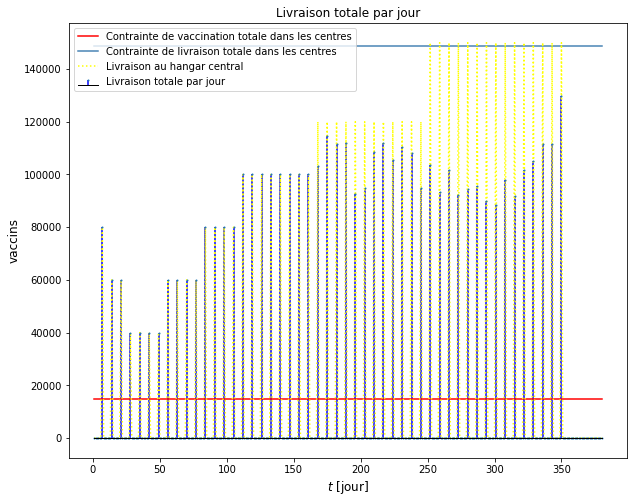

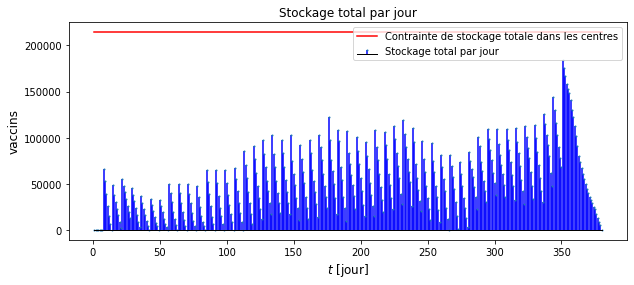

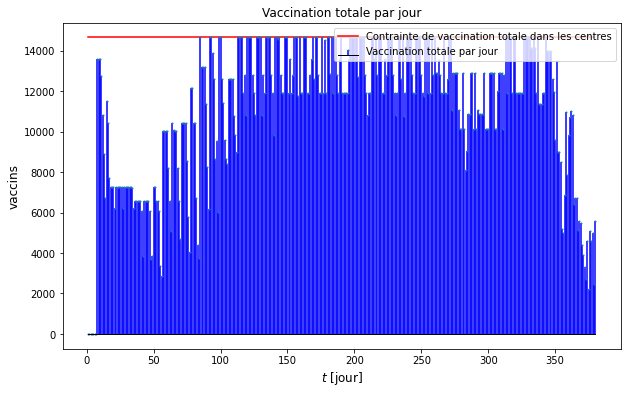

In [17]:
bilan_livraisons   = [sum(x[t][j].x for j in range(n)) for t in days_2-1]
bilan_stockage     = [sum(z[t][j].x for j in range(n)) for t in days_2-1]
bilan_vaccinations = [sum(y[t][j][i].x for j in range(n) for i in range(m)) for t in days_2-1]
population_vaccinable = [sum(v_s[t][j][i].x for j in range(n) for i in range(m)) for t in days_2-1]
    
plot_bilan(days_2, bilan_livraisons, "Livraison totale par jour", 
           np.ones_like(days_2)*sum(b_v), np.ones_like(days_2)*sum(b_l), b_c, 
           linestyle=['solid', 'solid', 'dotted', 'solid'], 
           constr_name=["Contrainte de vaccination totale dans les centres", "Contrainte de livraison totale dans les centres", 
                        "Livraison au hangar central"],
           label_loc='upper left', figsize=(10,8))

plot_bilan(days_2, bilan_stockage, "Stockage total par jour", np.ones_like(days_2)*sum(b_s), 
           linestyle=['solid'], constr_name=["Contrainte de stockage totale dans les centres"], label_loc='upper right')

plot_bilan(days_2, bilan_vaccinations, "Vaccination totale par jour", np.ones_like(days_2)*sum(b_v)
           , linestyle=['solid'], constr_name=["Contrainte de vaccination totale dans les centres"], 
           label_loc='upper right', figsize=(10,6))

**Analyse des graphes**

Nous avons ici effectué un bilan global sur toute les populations et toutes les provinces des livraisons, stockages et vaccinations. 
On observe sur le premier graphe que nous transportons la totalité des vaccins disponibles au hangar central pendant les 160 premiers jours. La contrainte $b_c$ est donc active pendant cette première partie de la campagne. Pour toute la seconde partie, par contre, nous laissons une partie des vaccins au hangar central. 

Cela peut être expliqué par 2 facteurs. Premièrement, les livraisons au hangar se faisant de manière croissante, la contrainte de transport va finir par empêcher l'importation des vaccins dans les centres. Deuxièment, puisqu'il y a possibilité de stocker et que les contraintes de coût et de stockage ne sont pas serrées (comme cela est mis en évidence  sur le 2ème graphe), il est possible qu'il ne soit plus nécessaire de transporter de nouveaux vaccins en plus grande quantité.

Finalement, On observe sur le dernier graphe que la courbe des vaccinations a une allure similaire à celle des livraisons et que la contrainte de vaccination reste relativement active la plupart du temps. On note également qu'il y a présence d'un pic de stockage au jour 350. Cela nous permet de vacciner jusqu'au 380ème$ jour.

#### Graphes des populations

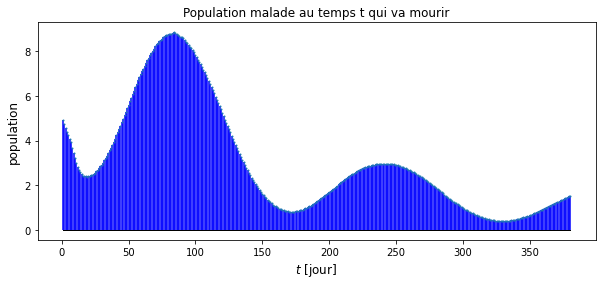

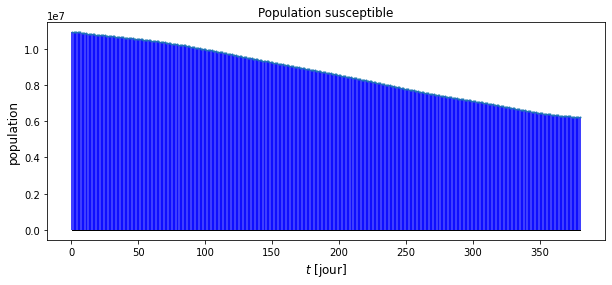

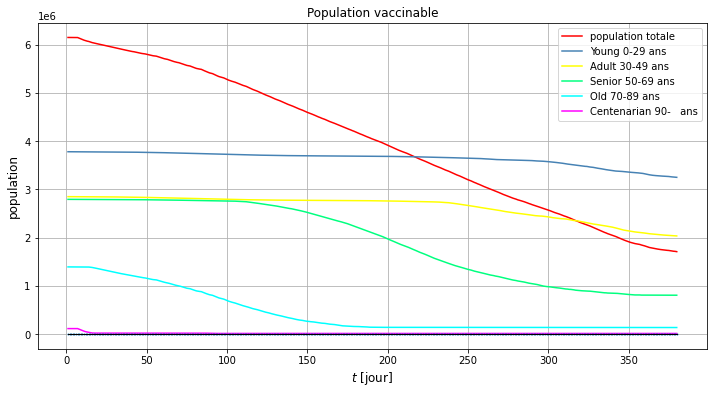

In [18]:
plot_bilan(days_2, pop_morte, "Population malade au temps t qui va mourir",label=False,ylabel='population')
plot_bilan(days_2, population, "Population susceptible",label=False,ylabel='population')

plot_bilan(days_2, np.zeros_like(population_vaccinable), "Population vaccinable",
            population_vaccinable,
           [population_classe[t][0] for t in days_2-1],
           [population_classe[t][1] for t in days_2-1],
           [population_classe[t][2] for t in days_2-1],
           [population_classe[t][3] for t in days_2-1],
           [population_classe[t][4] for t in days_2-1],
           linestyle=['solid']*6,
           constr_name=["population totale"] + populationNames,
           label_loc='upper right', figsize=(12,6), label=False,ylabel='population',grid=True)

**Analyse des graphes**

On remarque que le premier graphe suit une progression sinusoïdale avec un premier grand pic et un second plus faible. Il s'agit d'une conséquence de l'hypothèse selon laquelle les coefficients $\lambda$ et $\varepsilon$ sont des fonctions sinusoïdales du temps. Par ailleurs, comme nous le montre le deuxième graphe, le second pic est plus faible que le premier car la population de susceptibles diminue dans le temps grâce aux vaccinations.

Nous observons ensuite, sur le second graphe, l'évolution de la population susceptible et vaccinable en fonction du temps, et ce pour la population globale (en rouge) et pour les différentes classes d'âges prises séparément (en d'autres couleurs).
Pour une classe d'âge, une augmentation de la pente de la courbe correspond à la période sur laquelle la vaccination de cette classe est importante. En effet, le fait de tomber malade a un impact bien moindre sur la diminution de la population que le fait de vacciner.

In [19]:
SommeL  = [sum(livraisons[j][t] for t in days_2-1) for j in range(n)]
SommeV  = [sum(y[t][j][i].x for j in range(n) for t in days_2-1) for i in range(m)]
SommeR  = [sum(y[t][j][i].x for i in range(m) for t in days_2-1) for j in range(n)]
SommeMV = [sum(epsilon_t[i,t] * lambda_t[t][i][j] * (v_s[t][j][i].x) for t in days_2-1 for j in range(n)) for i in range(m)]
SommeMT = [sum(epsilon_t[i,t] * lambda_t[t][i][j] * (v_s[t][j][i].x + n_s[t][j][i]) for t in days_2-1 for j in range(n)) for i in range(m)]
SommeMR = [sum(epsilon_t[i,t] * lambda_t[t][i][j] * (v_s[t][j][i].x + n_s[t][j][i]) for t in days_2-1 for i in range(m)) for j in range(n)]
# Plot des livraisons
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n".format(pct)

def circle(data,labels,name,namePlot):
    fig, ax = plt.subplots(figsize=(6, 9), subplot_kw=dict(aspect="equal"))
    wedges, texts , autotexts = ax.pie(data, colors=colors, wedgeprops=dict(width=0.35), pctdistance=0.825, autopct=lambda pct: func(pct, SommeL), startangle= 45, textprops=dict(color="k"))

    ax.legend(wedges, labels, loc="center", title=f"Liste des {name}", bbox_to_anchor=(1.4, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight="bold")
    ax.set_title(namePlot, fontsize=15)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(float(f"{data[i]:.1f}"), xy=(x, y), xytext=(1.3*np.sign(x), 1.1*y),
                    horizontalalignment=horizontalalignment, **kw)
    plt.show()

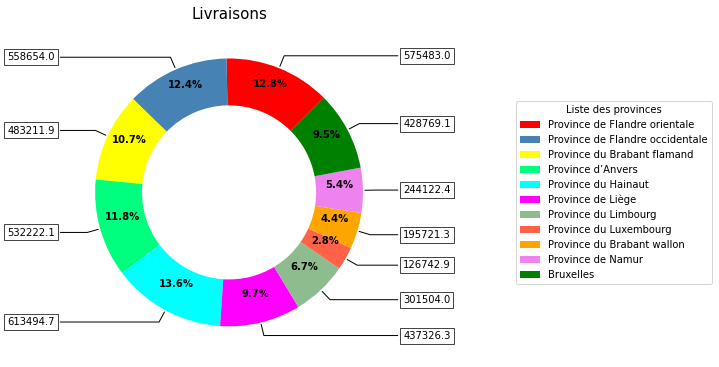

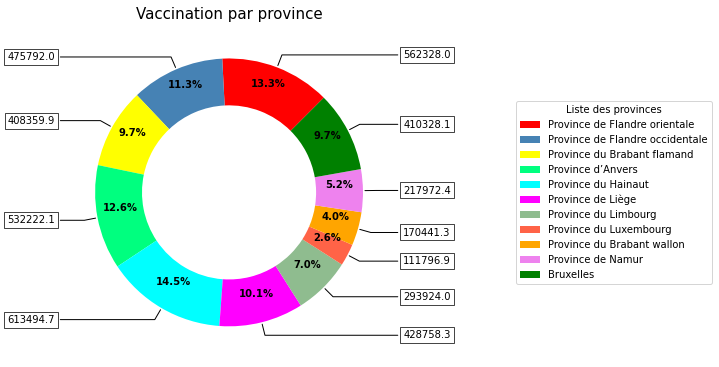

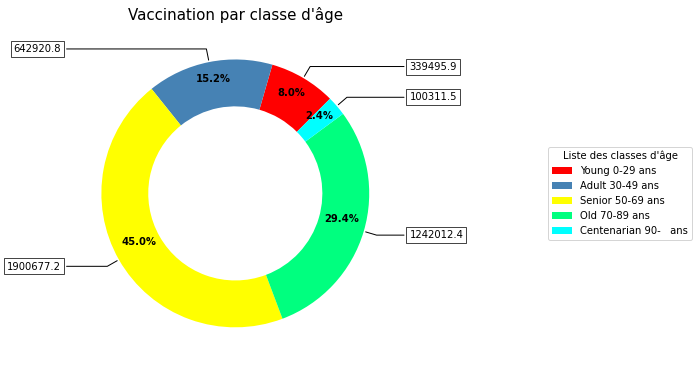

In [20]:
circle(SommeL,province,"provinces","Livraisons")
circle(SommeR,province,"provinces","Vaccination par province")
circle(SommeV,populationNames,"classes d'âge","Vaccination par classe d'âge")

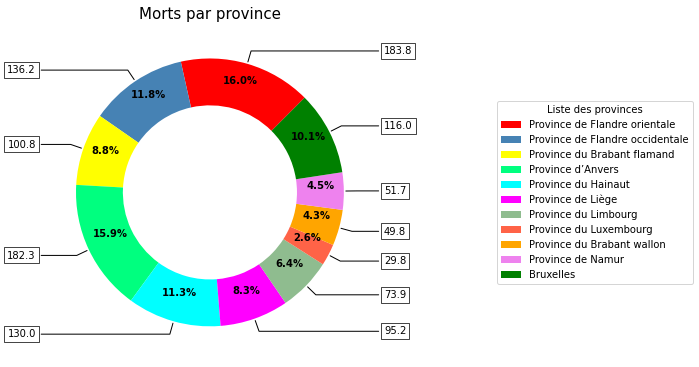

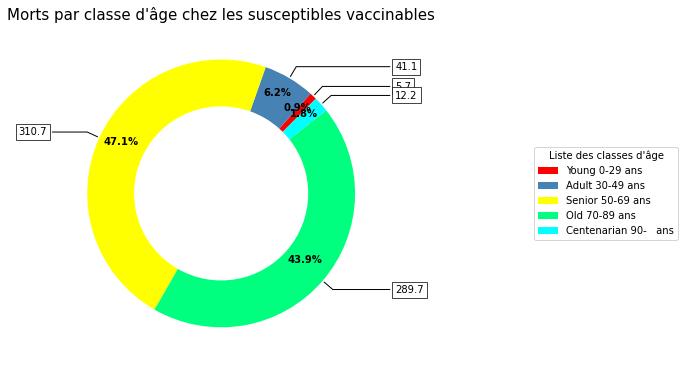

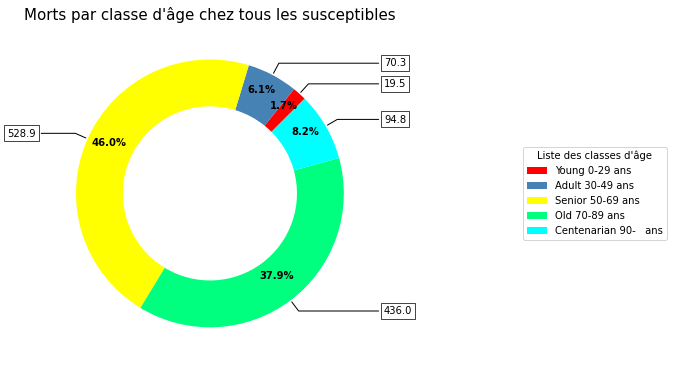

In [21]:
circle(SommeMR,province,"provinces","Morts par province")
circle(SommeMV,populationNames,"classes d'âge","Morts par classe d'âge chez les susceptibles vaccinables")
circle(SommeMT,populationNames,"classes d'âge","Morts par classe d'âge chez tous les susceptibles")

**Analyse des graphes**

Les graphes en anneau présentés ci-dessus donne un bilan global sur toute la campagne des livraisons, vaccinations et morts par classe d'âge ou par région. 

Tout d'abord concernant les régions, on remarque une demande plus forte chez certaines en terme de livraisons et de vaccinations. Il s'agit principalement des provinces d'Anvers, du Hainaut, de la Flandre orientale et de la Flandre occidentale qui ont respectivement des pourcentages de 13.6%, 11.8%, 12.8 et 12.4% pour les livraisons et 14.5%, 12.6%, 13.3% et 11.3% pour les vaccinations. On observe qu'il s'agit des régions pour lesquelles la mortalité y est plus élevée (11.3%, 15.9%, 16% et 11.8% respectivement). On note que le nombre de morts au Hainaut est plus faible que dans la province d'Anvers et de Flandre orientale. Cela s'explique par le fait que nous avons privilégié les vaccinations dans cette province et que dans le cas contraire, le nombre de morts aurait fini par dépasser celui dans les autres régions.

Ensuite, pour ce qui est des classes d'âge, on observe qu'en terme de pourcentage, les vaccinations d'une classe d'âge et les morts dans cette même classe sont relativement similaire. Cela nous semble logique dans la mesure où l'on vaccine les populations qui ont le plus de chance de mourir. On note toutefois que le nombre de vaccinations chez les 'young' est plus élevé que chez les 'centenarian' marlgré qu'on ait plus de morts chez ces derniers. Une partie des 'centenarian' morts ($12.2$ personnes) correspond à ceux que nous n'avons pas pu sauver (car ils sont tombés malade trop tôt), tandis que la seconde partie $(94.8 - 12.2 = 82.6)$ correspond à la population qu'on ne peut pas vacciner car nous n'y sommes pas autorisés. 

#### Analyse globale des résultats obtenus

La différence avec la question précédente réside dans le fait que l'on ait beaucoup plus de vaccins à disposition, ce qui fait que l'on peut vacciner au maximum les 2 classes les plus âgées. Il nous reste, en effet, des vaccins à administrer sur une partie de la classe de 'young' (0-29 ans). 

L'analyse des graphes fait ressortir un fait étonnant : notre modèle vaccine une certaine proportion de jeunes (8%) sans pour autant totalement vacciner les 2 classes ainées qui sont les 'adult' (30-49 ans) et 'senior' (50-69 ans).

A la lecture des graphiques, on peut comprendre que notre modèle maximise la livraison vers les provinces où la population totale est la plus élevée ou celles où les populations appartenant aux classes les plus âgées sont les plus grandes. Le modèle cherche à réguler au mieux en jouant avec les différents coefficients, c'est ce qui fait qu'il livre plus dans certaines provinces (Hainaut, Anvers, Flandre orientale) que d'autres (Brabant Wallon, Luxembourg, Namur).

Cependant, l'ordre dans lequel on vaccine reste similaire à celui de la question 1.1. On cherche toujours à vacciner au maximum les classes les plus âgées avant d'entamer les suivantes (les plus jeunes).

Finalement, en se focalisant sur les graphes de livraison et de stockage, on peut facilement se convaincre de l'exactitude de notre modèle.
En effet, les "pics de stockage" que l'on peut voir sur les graphes suivent bien ceux de livraison.
De plus, après ces pics, on peut souvent voir des chutes dans les graphes de stockage qui correspondent à la consommation du stock avant un nouveau remplissage.

A la fin de la période de livraison, on peut finalement remarquer que les graphes de stockage présentent des valeurs non-nulles après 350 jours.
En effet, les stockages continuent de se vider après la période de livraison ce qui permet de vacciner jusqu'au jour 380 et de maximiser les vaccinations autant que possible.

### Question 1.3$^1$
Pour estimer l'impact de la variation d'une contrainte sur la fonction objectif, on considère la solution du problème dual que l'on note $y_*$. D'après le cours théorique, nous savons que pour une variation $\Delta b$ du vecteur des contraintes $b$, la valeur de la fonction objectif

$$z = y_*^T b\ ,$$
sera modifiée d'une valeur
$$\\ \Delta z = y_*^T \Delta b.$$


Dans cette question, $\beta \in ]0,1[$ désigne une certaine tolérence sur la variation $\Delta b$ par rapport à la valeur originale $b$. Typiquement, nous imposerons que 

$$\Delta b \leq \beta b.$$

De cette manière, cela nous permet d'obtenir des résultats pertinents sur la variation de l'objectif, puisque la formule faisant intervenir la solution du dual ne fonctionne que pour des petites variations $\Delta b$.

<sup>1</sup> Pour cette question, le symbole $^T$ signifie la transposée.

In [22]:
y_star = np.array([contrainte.pi for contrainte in model_I2.constrs])
y_star[np.absolute(y_star) < 1e-9] = 0
print(f"y_star = {y_star}")

# Sauvegarde des valeurs dans un fichier
#with open("y_star.txt", 'w') as f:
#    for i in y_star:
#        f.write(str(i) + "\n")

y_star = [ 0.         -0.00093773 -0.0009008  ...  0.00058944  0.
  0.00077745]


#### (a) 
Pour une variation $\Delta c_{tot}$ du budget total, $\Delta b = (\Delta c_{tot},\ 0,\ 0,\ \cdots,\ 0)$
puisqu'il s'agit de notre première contrainte.

In [23]:
# APO = Analyse post optimale

def APO_c_tot(beta):
    delta_b = np.zeros_like(y_star)
    delta_b[0] = beta * c_tot
    delta_z = y_star @ delta_b
    print(f"  {beta:.3f} | {delta_z:.2f}")

print("  {:^6}| {}".format("beta", "Delta z"))
print("  ---------------")
for beta in [1e-3, 5e-3, 1e-2, 1.2]:
    APO_c_tot(beta)

   beta | Delta z
  ---------------
  0.001 | 0.00
  0.005 | 0.00
  0.010 | 0.00
  1.200 | 0.00


On observe que pour toute valeur de $\beta$, même $>1$, la variation de l'objectif $\Delta z$ est identiquement nulle. 
En effet, la contrainte de budget total n'étant pas active, la composante de la solution du dual associée à cette contrainte sera nulle par la relation d'exclusion. Dès lors, pour toute modification suffisamment faible $\Delta c_{tot}$ du budget total, $\Delta z$ sera nul.

#### (b)
On souhaite à présent déterminer la modification sur la quantité de vaccins disponible nécessaire pour diminuer d'une personne le nombre de morts. On note par $\Delta b_c$ le vecteur des modifications sur les quantités disponibles, de même taille que $b_c$. On souhaite donc trouver $\Delta b$ tel que 

$$y_*^T \Delta b = a^T \Delta b_c = -1$$

où $\Delta b_c$ correspond aux composantes non nulles de $\Delta b$ et $a$ est le vecteur des composantes de $y_*$ associées à $\Delta b_c$.

On constate que le nombre d'équations est inférieur au nombre d'inconnues. On effectue donc une approximation au sens de la norme $1$ (ou de la norme $\infty$). En outre, on impose que $\Delta b$ reste suffisamment faible par rapport à $b$. Le problème s'écrit 

$$\begin{eqnarray*}
& min_{\ t,\Delta b_c} &\ t &\\
a^T \Delta b_c + 1 & \ge & -t \\
a^T \Delta b_c + 1 & \leq & t \\
(\Delta b_c)_k & \leq & \beta\ b_c^k \qquad \forall k, \quad \beta < 1
\end{eqnarray*}$$



$$%OLD VERSION$$
$$%On constate que le nombre d'équations est inférieur au nombre d'inconnues. On effectue donc une approximation au sens des moindres carrés de la manière suivante:
%A^T A x = A^T u
%avec
%A = \begin{pmatrix}
%  &   &   &   & y_*^T &        &   &   \\
%1 & 0 & \cdots & 0 & 0 & 0 & \cdots & 0 & 0 \\
%0 & 0 & \cdots & 0 & 1 & 0 & \cdots & 0 & 0 \\
%0 & 0 & \cdots & 0 & 0 & 1 & \cdots & 0 & 0 \\
%\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
%0 & 0 & \cdots & 0 & 0 & 0 & \cdots & 0 & 0 \\
%0 & 0 & \cdots & 0 & 0 & 0 & \cdots & 1 & 0 \\
%0 & 0 & \cdots & 0 & 0 & 0 & \cdots & 0 & 1 \\
%\end{pmatrix}; \qquad u =  \begin{pmatrix} -1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{pmatrix}; \qquad x = \Delta b$$


In [24]:
def approx_delta(a, b, beta):
    """ 
    minimisation de la valeur absolue des résidus
        min |a^T x + 1| sc x <= beta * b
    """
    model = Model('residus', sense=MINIMIZE)
    delta_b = np.array([model.add_var() for _ in range(len(a))])
    t = model.add_var()
    model.objective = minimize(t)

    model += xsum(a * delta_b) + 1 + t >= 0
    model += xsum(a * delta_b) + 1 - t <= 0

    for i in range(len(delta_b)):
        model += delta_b[i] <= beta * b[i]

    model.optimize()
    return model, delta_b

Variation du nombre de vaccins disponbibles dans le hangar central par jour pour diminuer d'un mort

Delta z = -1.00


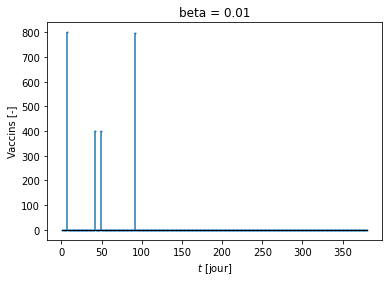

Delta z = -1.00


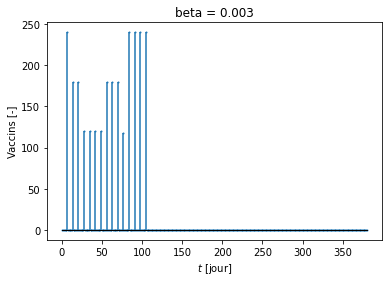

Delta z = -0.03


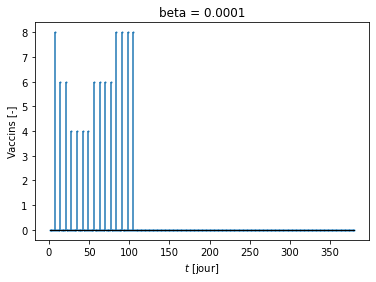

In [25]:
# Résolution du problème
def APO_b_c(tol):
    a = y_star[1:len(b_c)+1]
    q13_b, delta_b_c = approx_delta(a, b_c, tol)

    delta = np.array([delta_b_c[i].x for i in range(len(delta_b_c))])
    #print(delta)
    print(f"Delta z = {a @ delta:.2f}")
    
    plt.figure()
    plt.title(f"beta = {tol}")
    markerline, stemlines, baseline = plt.stem(days_2, delta)
    plt.xlabel("$t$ [jour]", fontsize=10)
    plt.ylabel("Vaccins [-]", fontsize=10)
    baseline.set_color('k')
    baseline.set_linewidth(1)
    markerline.set_markersize(1)
    plt.show()  
    
    q13_b.write(f"test b_c {tol}.sol")
    return delta

print("Variation du nombre de vaccins disponbibles dans le hangar central par jour pour diminuer d'un mort\n")
for beta in [1e-2, 3e-3, 1e-4]:   
    APO_b_c(beta)

On peut vérifier que nous diminuons bien de $1$ le nombre de morts en résolvant notre modèle avec cette modification.
On observe une légère différence par rapport à la valeur prédite grâce à la solution du dual, car $y_*^T \Delta b$ donne seulement une valeur approchée sur la modification de la valeur de l'objectif.

Delta z = -1.00


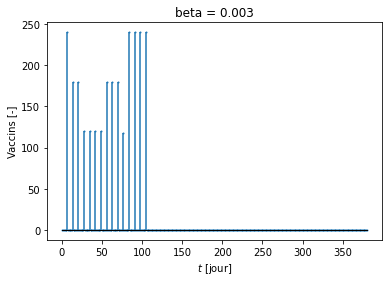

OptimizationStatus.OPTIMAL
f(x,y,z) = 658.5384878327968

valeur initiale de l'objectif : 659.3158306475787


In [26]:
solve_model(APO_modif='b_c', modif=APO_b_c(3e-3))
print(f"\nvaleur initiale de l'objectif : {model_I2.objective_value}")

#### Analyse des résultats

La solution obtenue, après résolution du problème de minimisation des résidus, nous indique qu'il est possible de diminuer de $1$ le nombre de morts si l'on rend disponible une certaine quantité de vaccins lors des $105$ premiers jours de la campagne. On observe que c'est toujours le cas pour différentes valeurs de $\beta$. 

On observe sur le graphe ci-dessous que la contrainte de 
Si l'on analyse le vecteur $a$ (défini plus haut), on peut remarquer que ses premières composantes auront une valeur plus élevée que ses dernières composantes. Cela signifie que rendre disponible les vaccins au hangar central en début de campagne aura un impact plus élevé sur les vaccinations (i.e l'objectif) que s'ils étaient rendus disponibles en fin de campagne. Cela nous semble logique dans la mesure où la contrainte de coût n'est pas active. En effet, dans ce cas, tout vaccin livré pourra être stocké dans un centre et être utilisé au moment qui convient le mieux.

Par ailleurs, comme cela a été mentionné plus haut lors de l'analyse des résultats, nous avons observé que la contrainte de livraison n'était serrée que sur la première moitiée de la campagne (environ les 160 premiers jours).
Cela signifie que, passé ce 160ème jour, il est inutile d'augmenter la livraison au hangar central. Cela correspont effectivement au résultat que nous obtenons sur les graphes ci-dessus.

Finalement, il faut noter qu'il s'agit ici que d'une seule possiblité de réduire le nombre de mort d'une unité. Il en existe en pratique une infinité.

#### (c) 
On estime l'impact d'une modification sur les contraintes de capacités et de coût de manière similaire au point (b). On remplace donc dans l'énoncé précédent $\Delta b_c$ successivement par $\Delta b_v$ le vecteur des modifications sur les vaccins administrables et $\Delta b_l$ le vecteur des modifications sur les vaccins livrables.


Variation du nombre de vaccins administrables dans chaque région et par jour pour diminuer d'un mort:

Delta z = -0.06
beta = 0.001


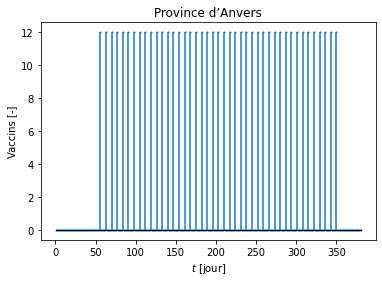

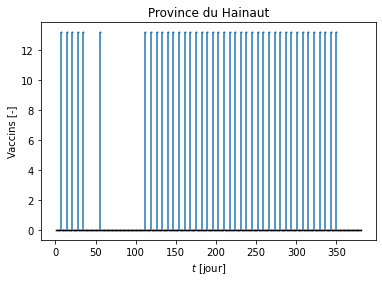

Delta z = -1.00
beta = 0.02


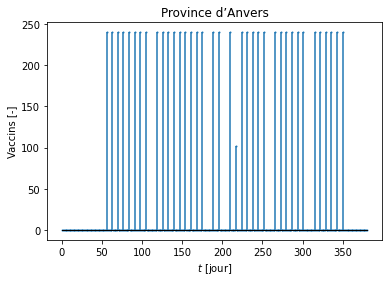

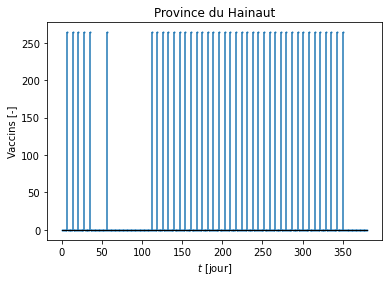

Delta z = -1.00
beta = 0.05


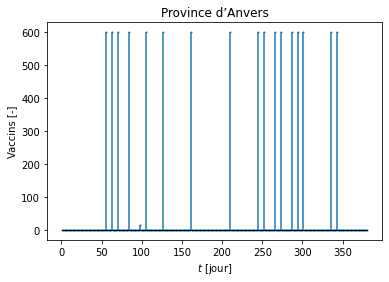

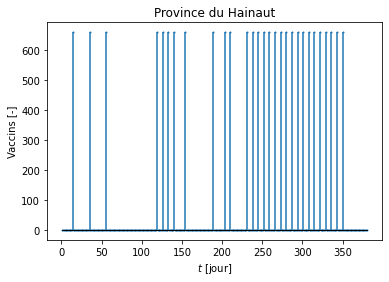

In [27]:
def APO_b_l(beta):    
    b1 = [b_l[j] for t in days_2-1 for j in range(n)]
    a1 = y_star[len(b_c)+1:len(b_c)+len(b1)+1]

    q13_c1, delta_b_l = approx_delta(a1, b1, beta)

    delta_bl = np.array([[delta_b_l[j+t*n].x for t in days_2-1] for j in range(n)])
    delta1 = np.array([delta_b_l[j+t*n].x for t in days_2-1 for j in range(n)])
    print(f"Delta z = {a1 @ delta1:.2f}")
    print(f"beta = {beta}")
    for j in range(n):
        if np.any(delta_bl[j]):
            plt.figure()
            plt.title(province[j])
            markerline, stemlines, baseline = plt.stem(days_2, delta_bl[j])
            plt.xlabel("$t$ [jour]", fontsize=10)
            plt.ylabel("Vaccins [-]", fontsize=10)
            baseline.set_color('k')
            baseline.set_linewidth(1)
            markerline.set_markersize(1)
            plt.show()  

    return delta_bl

print("\nVariation du nombre de vaccins administrables dans chaque région et par jour pour diminuer d'un mort:\n")
for beta in [1e-3, 2e-2, 5e-2]:
    APO_b_l(beta)

Delta z = -1.00
beta = 0.02


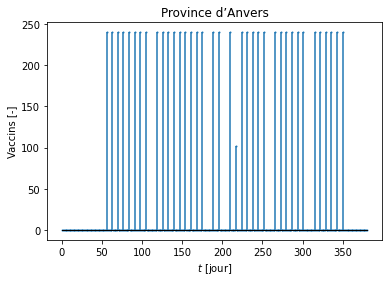

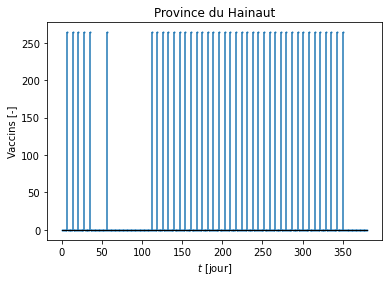

OptimizationStatus.OPTIMAL
f(x,y,z) = 658.3723082760134

valeur initiale de l'objectif : 659.3158306475787


In [28]:
# Vérification
solve_model(APO_modif='b_l', modif=APO_b_l(2e-2))
print(f"\nvaleur initiale de l'objectif : {model_I2.objective_value}")

In [29]:
# modification du nombre de vaccins administrables par jour dans chaque centre.
def APO_b_v(beta):
    b2 = [b_v[j] for t in days_2-1 for j in range(n)]
    a2 = y_star[len(b_c)+len(b2)+1:len(b_c)+2*len(b2)+1]

    q13_c2, delta_b_v = approx_delta(a2, b2, beta)

    delta_bv = np.array([[delta_b_v[j+t*n].x for t in days_2-1] for j in range(n)])
    delta2 = np.array([delta_b_v[j+t*n].x for t in days_2-1 for j in range(n)])
    print(f"Delta z = {a2 @ delta2:.2f}")
    print(f"beta = {beta}")
    for j in range(n):
        if np.any(delta_bv[j]):
            plt.figure()
            plt.title(province[j])
            markerline, stemlines, baseline = plt.stem(days_2, delta_bv[j])
            plt.xlabel("$t$ [jour]", fontsize=10)
            plt.ylabel("Vaccins [-]", fontsize=10)
            baseline.set_color('k')
            baseline.set_linewidth(1)
            markerline.set_markersize(1)
            plt.show()
    
    return delta_bv


Variation du nombre de vaccins livrable dans chaque région et par jour pour diminuer d'un mort:

Delta z = -1.00
beta = 0.05


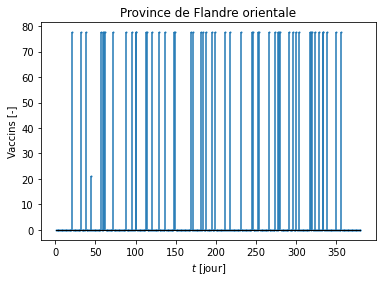

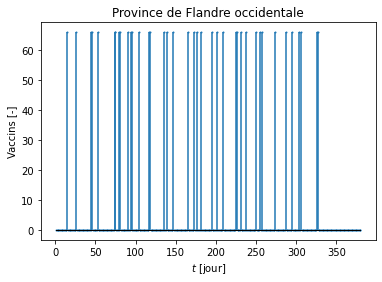

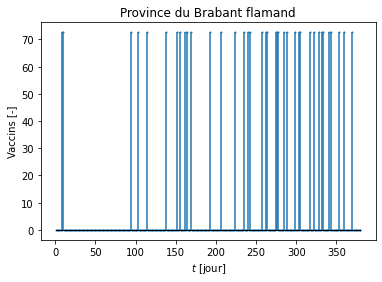

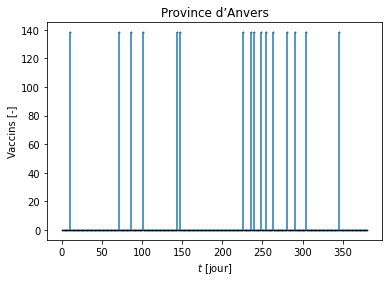

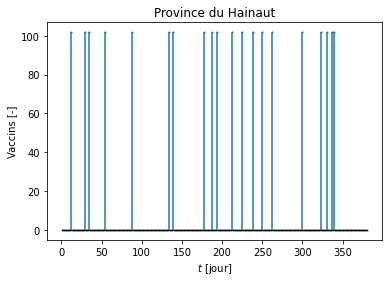

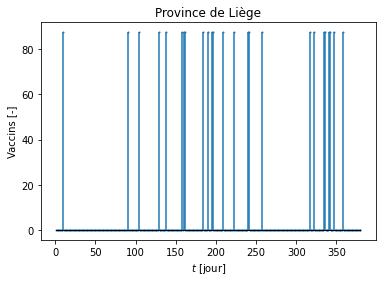

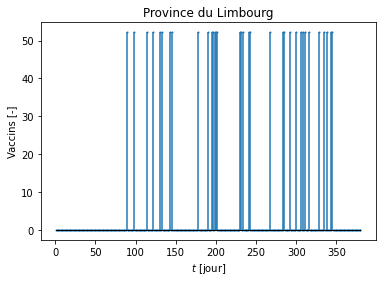

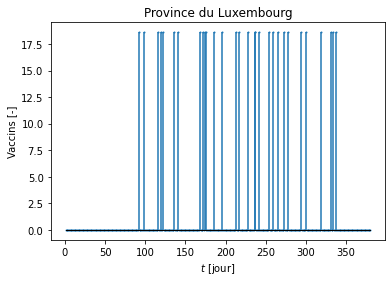

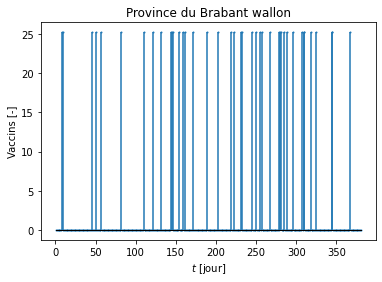

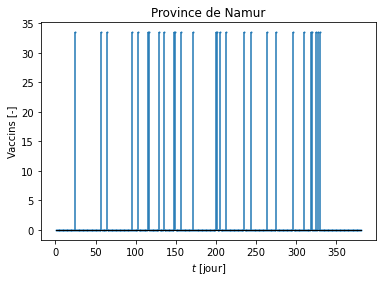

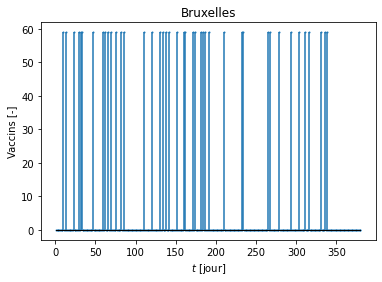

OptimizationStatus.OPTIMAL
f(x,y,z) = 658.2369853218288

valeur initiale de l'objectif : 659.3158306475787


In [30]:
# Vérification
print("\nVariation du nombre de vaccins livrable dans chaque région et par jour pour diminuer d'un mort:\n")
delta_bv = APO_b_v(5e-2)
solve_model(APO_modif='b_v', modif=delta_bv)
print(f"\nvaleur initiale de l'objectif : {model_I2.objective_value}")


Variation du nombre de vaccins stockable dans chaque région et par jour pour diminuer d'un mort:

Delta z = -0.00
beta = 0.001


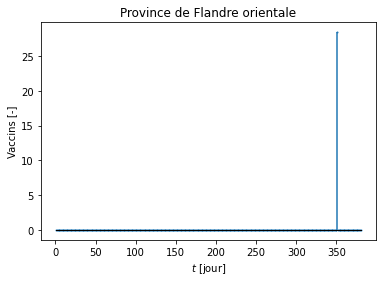

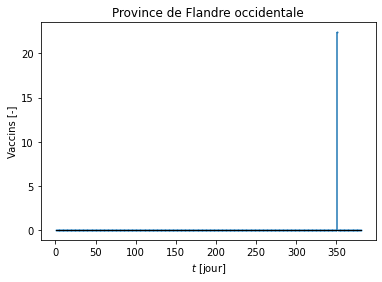

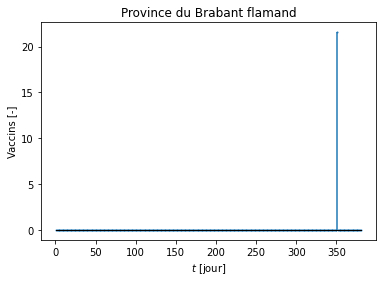

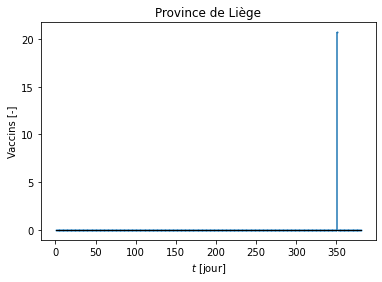

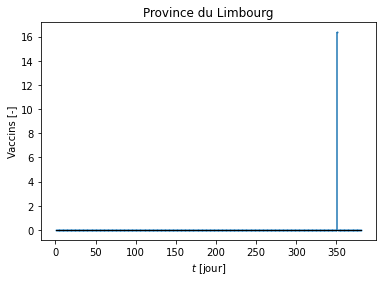

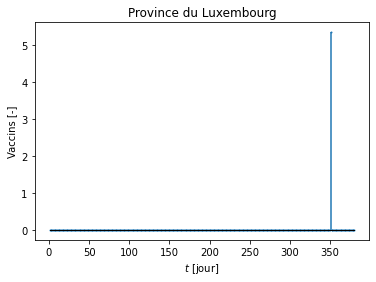

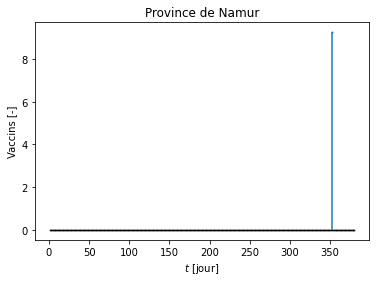

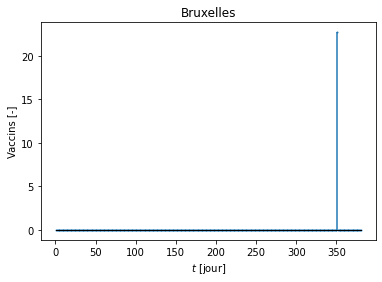

Delta z = -0.00
beta = 0.01


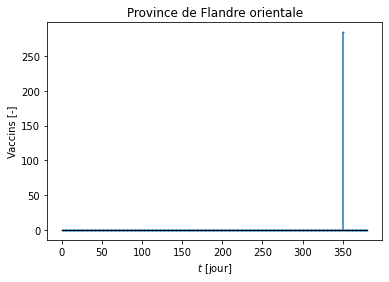

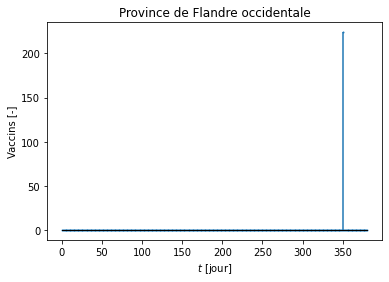

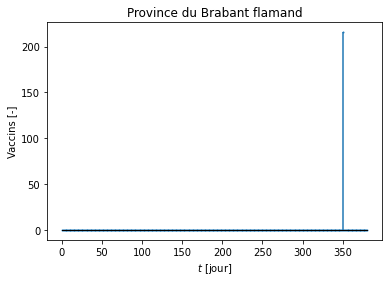

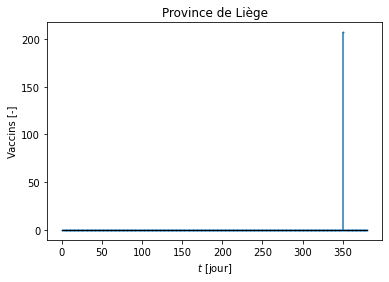

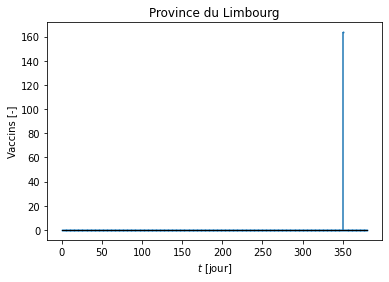

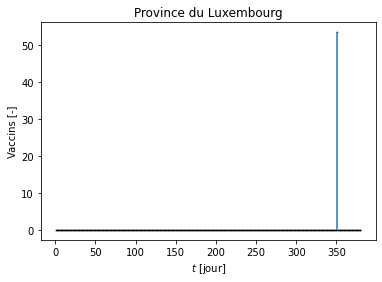

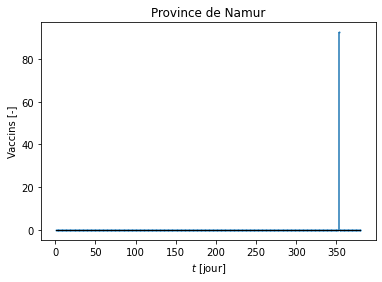

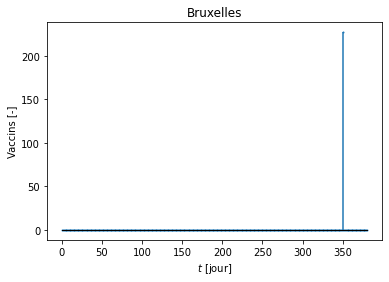

Delta z = -0.01
beta = 0.05


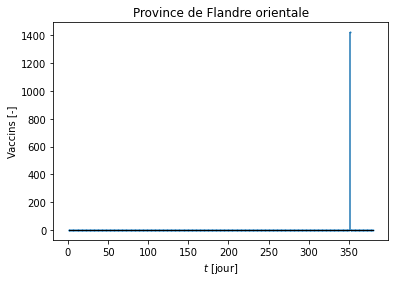

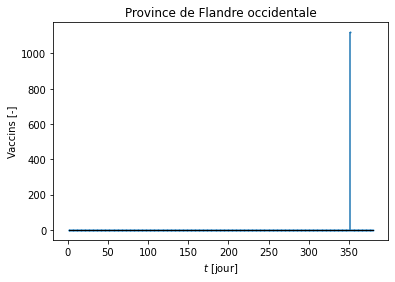

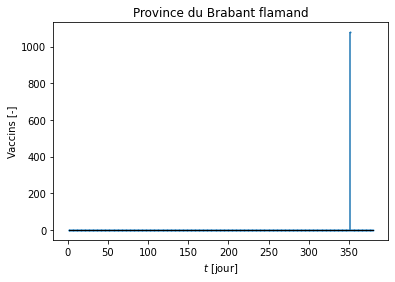

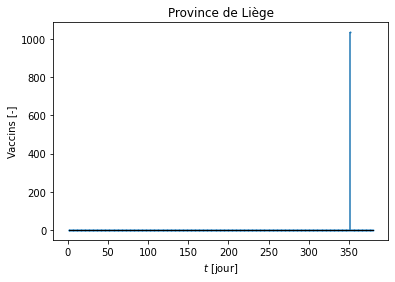

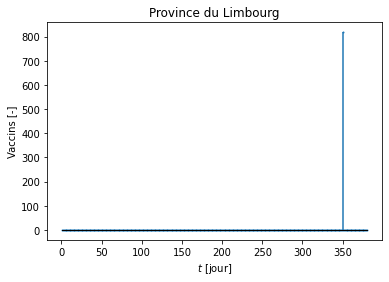

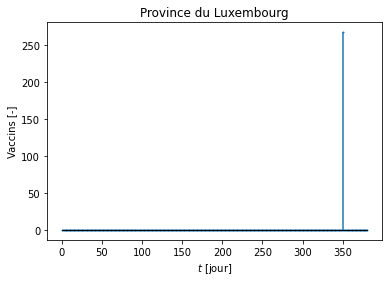

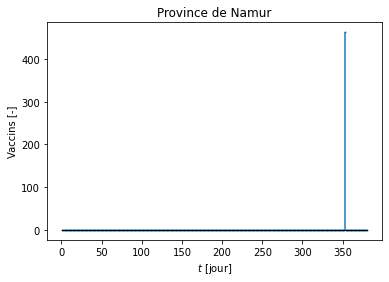

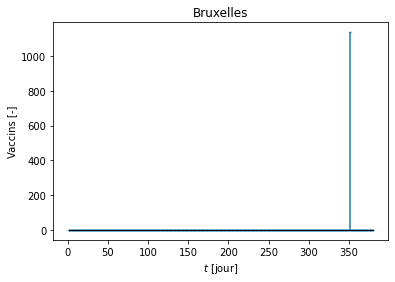

In [31]:
# modification du nombre de vaccins administrables par jour dans chaque centre.
def APO_b_s(beta):
    b3 = [b_s[j] for t in days_2-1 for j in range(n)]
    a3 = y_star[len(b_c)+2*len(b3)+1:len(b_c)+3*len(b3)+1]

    q13_c3, delta_b_s = approx_delta(a3, b3, beta)

    delta_bs = np.array([[delta_b_s[j+t*n].x for t in days_2-1] for j in range(n)])
    delta3 = np.array([delta_b_s[j+t*n].x for t in days_2-1 for j in range(n)])
    print(f"Delta z = {a3 @ delta3:.2f}")
    print(f"beta = {beta}")
    for j in range(n):
        if np.any(delta_bs[j]):
            plt.figure()
            plt.title(province[j])
            markerline, stemlines, baseline = plt.stem(days_2, delta_bs[j])
            plt.xlabel("$t$ [jour]", fontsize=10)
            plt.ylabel("Vaccins [-]", fontsize=10)
            baseline.set_color('k')
            baseline.set_linewidth(1)
            markerline.set_markersize(1)
            plt.show()
    
    return delta_bs

print("\nVariation du nombre de vaccins stockable dans chaque région et par jour pour diminuer d'un mort:\n")
for beta in [1e-3, 1e-2, 5e-2]:
    APO_b_s(beta)


In [32]:
# Vérification
# solve_model(APO_modif='b_s', modif=APO_b_s(1e-1))
# print(f"\nvaleur initiale de l'objectif : {model_I2.objective_value}")

#### Analyse des résultats

Les graphes tracés ci-dessus correspondent à la modification des différentes limites sur les capacités du problème (livraison, vaccination et stockage) par jour, et ce uniquement pour les régions où cette modification est non-nulle. 

* (1) **Modification de la limite de vaccins livrables aux centres de vaccinations $\Delta b_l$**:

Pour les différentes valeurs de $\beta$, seule les provinces d'Anvers et du Hainaut sont concernées par cette modification. D'une part, on observe dans les données qu'il s'agit de $2$ régions où la limite de livrasion est plus faible ($12000$ pour Anvers) que dans d'autres régions ($15600$ pour le Brabant Wallon). D'autre part, en reprenant le graphe circulaire de la question $1.2$ (voir ci-dessous), on constate qu'il s'agit des $2$ régions où l'on vaccine de manière plus important (12.6% et 14.5% respectivement) que dans d'autres régions.

Par ailleurs, comme cela a été discuté à la question 1.2, les graphes des livraisons pour les régions de Anvers et du Hainaut sont ceux pour lequels les contraintes de livraisons sont les plus actives. Il en découle donc qu'il sera plus facile de diminuer la valeur de l'objectif en relâchant cette contrainte pour ces $2$ régions en particulier.

* (2) **Modification de la limite de vaccins administrables $\Delta b_v$**:
   
Il s'agit ici d'un paramètre assez contraignant du point de vue de l'objectif. En effet, la résolution du modèle avec les données fournies nous indique que la contrainte de coût n'est pas active. Il en est de même pour les contraintes de stockage (comme cela a été commenté plus haut). Il ne reste donc plus que la contrainte sur les vaccins administrables quotidiennement. De ce fait, l'analyse post-optimale nous montre que la modification doit se faire dans toute les régions de façon relativement équitable. On remarque à nouveau que la limite sur la vaccination est plus fortement relâchée (d'un point de vue du nombre de vaccins) dans les provinces d'Anvers et du Hainaut par rapport aux autres provinces. 

* (3) **Modification de la limite vaccins stockables $\Delta b_s$**:

Comme cela a été mentionné plus haut, la limite de stockage ne semble pas jouer un rôle important dans la diminution du nombre de $1$ mort supplémentaire. En effet la contrainte n'est pas active. C'est pourquoi, il n'est pas possible pour une modification faible de cette contrainte de diminuer de $1$ le nombre de mort.

On observe cependant que la solution proposée par la minimisation des résidus au sens de la norme $1$ n'est pas nulle pour tout temps $t$. En $t = 350$, on observe une demande non-nulle de relaxation sur la contrainte de stockage. Cela coïncide avec la dernière livraison de la campagne. Il semble donc logique d'augmenter les vaccins stockable ce jour-là afin de continuer à maximiser la vaccination une fois les livraisons terminées.

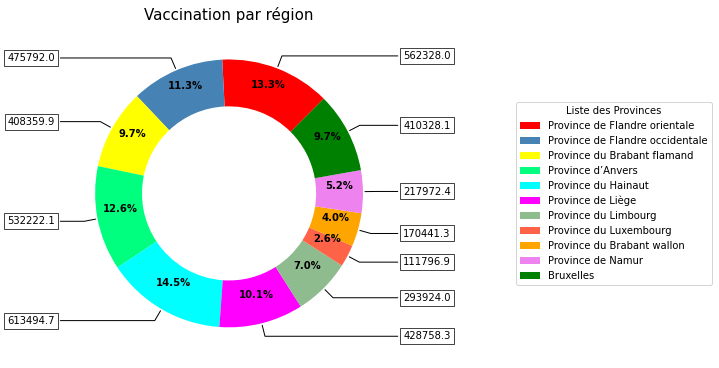

In [34]:
circle(SommeR,province,"Provinces","Vaccination par région")

### Question 1.4

$(a)$ On introduit les variables $(w_1)_{j}^t$ et $(w_2)_{j}^t$ représentant la quantité de vaccins au prix $P_1$ et $P_2$ respectivement, achetée par la province $j$ au jour $t$ dans le stock $Q$. On impose que le nombre de vaccins achetés ne puisse pas dépasser le nombre de vaccins dans $Q$ chaque jour $(6)$ et $(7)$.

De plus, on ajoute le prix d'achat de ces vaccins supplémentaires dans la contrainte de coût total $(1)$. 

Finalement, on ajoute $w_1$ et $w_2$ dans la contrainte concernant les vaccins administrables et stockables chaque jour et dans chaque région $(8)$. On prend la convention que $(w_1)^0 = 0$ et $(w_2)^0 = 0$ pour les mêmes raisons qu'aux points 1.1 et 1.2.

Cela s'écrit donc:

$$\begin{eqnarray*}
\min_{x, y, z, v_s, w_1, w_2}& \sum_{t=1}^{T} \sum_{i=1}^{m} \sum_{j=1}^{n} \varepsilon_{ij}^t\ \lambda_{ij}^t 
(v_s)_{ij}^t & \\
\sum_{t=1}^T \sum_{j=1}^{n} \left(c_{tr}\ x_j^t + c_v \sum_{i=1}^{m} y_{ij}^t + c_s z_j^t + P_1\ (w_1)_{j}^t + P_2\ (w_2)_{j}^t \right) &\leq& c_{tot} \tag{1}\\
\sum_{j=1}^n x_j^{t} &\leq & b_c^t \tag{2}\\ 
x_j^t &\leq& (b_l)_j^t \tag{3}\\
\sum_{i=1}^{m} y_{ij}^t &\leq& (b_v)_j^t \tag{4}\\
z_j^t &\leq& (b_s)_j^t \tag{5}\\
\sum_{j=1}^{n} (w_1)_{j}^t  & \leq & \frac{1}{2} Q \tag{6}\\
\sum_{j=1}^{n} (w_2)_{j}^t  & \leq & \frac{1}{2} Q \tag{7}\\
x_j^{t-1} + z_j^{t-1} + (w_1)_{j}^{t-1} +(w_2)_{j}^{t-1} - \sum_{i=1}^{m} y_{ij}^t - z_j^{t} &\geq& 0 \tag{8}\\
(v_s)_i^t - \left((1-\lambda_i^{t-1})\ (v_s)_i^{t-1} - y_i^{t} \right) &=&  0 \tag{9}\\
(v_s)_{ij}^0 &=& \mu_i\ (p_{init})_{ij}\tag{10}\\ 
x^0,\ y^0,\ z^0,\ (w_1)^0,\ (w_2)^0 &=& 0 \tag{11} \\
x,\ y,\ z,\ v_s,\ w_1,\ w_2 &\geq& 0 \tag{12}
\end{eqnarray*}$$

Lorsque cela n'est pas précisé, $t\in\{1,\ldots,T\}$, $i\in\{1,\ldots,m\}$ et $j\in\{1,\ldots,n\}$.

$(b)$ Pour estimer le nombre de décès une fois la campagne de vaccination terminée jusqu'au temps $S \in [T+1,\infty[$, c'est à dire à partir de $t = T+1$, jusqu'à $t = S$, nous pouvons fixer la fraction de malades $\lambda$ et de morts $\varepsilon$ à celles observées en $t = T$. 

Afin de simuler l'arrêt total de vaccination, nous posons : 
$$\forall t \in [T+1,S]\ : y_{ij}^{t} = 0 \quad \forall i,j$$

Notons également qu'aucune contrainte supplémentaire n'est a priori nécessaire pour les autres variables. En effet, à l'optimum, aucun vaccin ne sera ni livré, ni stocké si ces vaccins ne peuvent être administrés à cause des coûts non-nuls associés à ces opérations.

Si la fenêtre temporelle étudiée après la fin de la campagne de vaccination est infinie, la population susceptible vaccinable au temps $t = \infty$, $(v_s)_{ij}^\infty$, va tendre vers $0$. Dès lors, il suffit de calculer la population décédée jusqu'à un certain temps $N$ tel que pour $\epsilon \ll 1$: 

$$\left|(v_s)_{ij}^{r} - (v_s)_{ij}^{t} \right| < \epsilon \quad \forall r,t > N$$

En d'autres termes, on résout notre modèle jusqu'à un certain temps $N$ pour lequel $(v_s)_{ij}^t$ ne variera quasiment plus $\forall t > N$. Cela permet de ne pas poser une infinité de contraintes sur la variable $y$.

### Question 1.5

Nous avons identifié plusieurs hypothèses non-réalistes dans notre modèle. Nous avons décidé d'en développer deux en particulier :

Premièrement, les variables de décisions optimales sont continues alors qu'elles représentent des valeurs entières (vaccins, personnes, livraisons,...). Afin de modifier cela, il faudra implémenter un modèle en variables discrètes. Le modèle actuel nous renseigne sur une borne supérieure sur la valeur réelle de morts, de vaccins, etc.

Deuxièmement, la population dans chaque classe d'âge ne forme qu'un bloc uni. Il serait intéressant de faire des sous-classes selon plusieurs groupes de travailleurs, afin d'identifier ceux à risque : enseignant, personnes dans les centres hospitaliers, métiers de contact, etc. Pouvoir subdiviser les classes d'âge en professions permet de potentiellement ajouter le télé-travail dans l'équation, et donc indirectement le confinement de certaines populations de travailleurs. Ces classes seraient donc moins à risque et pourraient laisser leurs doses à des personnes ayant plus chance de décéder du virus, dû à leurs activités professionnelles et à leur âge.
Pour implémenter cela, il faudrait simplement ajouter des taux d'incidence selon les professions et subdiviser la population de chaque province en classes d'âge, qui elles mêmes seront divisées en professions. On ajoutera également, pour la classe d'âge 0-29, le travail "enfant" et "étudiant".

**Pour aller plus loin:** 

Le modèle que nous avons présenté dans ce document est déterministe dans le sens où nous connaissons à l'avance les proportions de la population qui va tomber malade et qui mourra. Il manque donc un aspect exponentiel à notre modèle, typique des épidémies virales. Afin d'y remédier, il faudrait pouvoir créer un lien plus fort entre la catégorie des malades et celle des suceptibles. 

En effet, dans le modèle actuel, nous considérons les susceptibles et les malades comme 2 catégories indépendantes, la seule intéraction existante étant le moment où une personne tombe malade pour diminuer la population de susceptible d'une part et augmenter celle des malades d'autre part.

Dès lors, il faudrait pouvoir simuler le fait qu'un malade soit contagieux. On considérera donc une durée de maladie fixée avec une certaine période d'incubation durant laquelle une personne sera contagieuse, ainsi qu'un coefficient de risques qu'un malade puisse contaminer une personne susceptible, selon sa classe d'âge.